In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import CHILDES_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

<ipython-input-3-5dad22dbb65b>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
transcript_df = pd.read_pickle(CHILDES_DFS/'childes_df_eng_corpora.pickle')
#transcript_df['dataset'] = [i[0].split('/')[11] for i in transcript_df.transcript_xml.values]
len(transcript_df)

7132

In [5]:
# mask for only a subset of corpuses
possible_corpuses = [
    # carterette is also transcribed in IPA
    "Carterette",  # 1st, 3rd, 5th grade, adults, speech naturalistic speech in IPA https://childes.talkbank.org/access/Eng-NA/Carterette.html
    "Gillam",  # normal subset, spontaneous storytelling 5-11y11m https://childes.talkbank.org/access/Clinical-MOR/Gillam.html
    "Braunwald",  # single subject from 1-6yo talking to family https://childes.talkbank.org/access/Eng-NA/Braunwald.html
    "Brown",  # 1y6m-5y1m, 3 subjects naturalistic talking to parents https://childes.talkbank.org/access/Eng-NA/Brown.html
    "EllisWeismer",  # 2y6m - 5y6 naturalistic play-oriented talk with instructor # https://childes.talkbank.org/access/Clinical-MOR/EllisWeismer.html
    "Gleason",  # 2;1 - 5;2 family interactions https://childes.talkbank.org/access/Eng-NA/Gleason.html
    "NH",# Nicholas-NH,  # 1;0-4;0, videotaped play with parent https://childes.talkbank.org/access/Clinical-MOR/Nicholas/NH.html
    "Post",  # 1;7-2;8 60m session with family and toys https://childes.talkbank.org/access/Eng-NA/Post.html
    "Normal",  #  Rondal-Normal 3-12yo free play with mother and child https://childes.talkbank.org/access/Clinical-MOR/Normal /Normal.html
]
corpus_mask = [corpus in possible_corpuses for corpus in transcript_df.corpus.values]
transcript_df = transcript_df[corpus_mask]

In [6]:
#transcript_df.to_pickle(CHILDES_DFS/'childes_df_eng_corpora.pickle')

In [7]:
# mask for a subset of roles
#possible_roles = ['Target_Child', 'Child']
#role_mask = [role in possible_roles for role in transcript_df.role.values]
#transcript_df = transcript_df[role_mask]
len(transcript_df)

7132

In [8]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS
5733,11312/c-00005910-1,eng,NH,1992-08-08,CHI,Target_Child,P4Y00M10D,eng,male,"[[], [], [pro:sub, mod~neg, v], [], [], [], [p...","[[], [], [I, don't, know], [], [], [xxx], [I, ...","[[], [], [I, do~not, know], [], [], [xxx], [I,...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,238,238,238
5734,11312/c-00005910-1,eng,NH,1992-08-08,MOT,Mother,NaN,eng,female,"[[v, pro:dem], [pro:int], [v, det:art, n], [mo...","[[use, this], [what], [use, the, stick], [can,...","[[use, this], [what], [use, the, stick], [can,...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,317,317,317
5735,11312/c-00005890-1,eng,NH,1992-10-29,CHI,Target_Child,P3Y06M04D,eng,female,"[[co, pro:sub, v], [pro:sub, v, pro:per~aux, p...","[[yeah, we, do], [I, think, it's, lost], [yeah...","[[yeah, we, do], [I, think, it~be, lose-PASTP]...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,302,302,302


In [9]:
PID_DF = pd.DataFrame(columns = ['PID', 'child_words', 'total_words', 'word_prop'])
for PID in tqdm(transcript_df.PID.unique(), total=len(transcript_df.PID.unique())):
    transcript_df_subset = transcript_df[transcript_df.PID == PID]
    child_words = transcript_df_subset[transcript_df_subset.role.isin(['Target_Child', 'Child'])].n_words.sum()
    total_words = transcript_df_subset.n_words.sum()
    PID_DF.loc[len(PID_DF)] = [
        PID, child_words, total_words, child_words/total_words
    ]
    
PID_DF[:3]

  0%|          | 0/2774 [00:00<?, ?it/s]

<ipython-input-9-e831f951d82b>:7: RuntimeWarning: invalid value encountered in long_scalars
  PID, child_words, total_words, child_words/total_words


,PID,child_words,total_words,word_prop
0,11312/c-00005910-1,238,555,0.428829
1,11312/c-00005890-1,302,657,0.459665
2,11312/c-00005874-1,275,612,0.449346


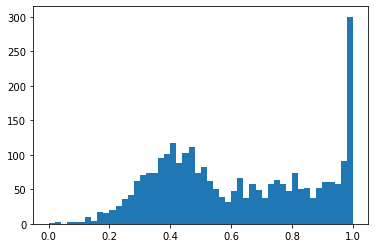

In [10]:
plt.hist(PID_DF.word_prop.values, bins=50);

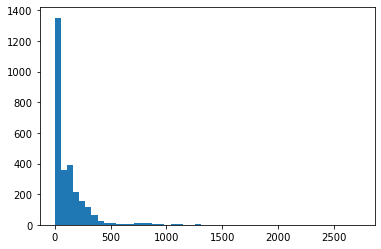

In [11]:
plt.hist(PID_DF.child_words.values, bins=50);

In [12]:
PID_DF.to_pickle(DATA_DIR/'mi/childes_word_prop.pickle')

In [13]:
transcript_df_subset.n_words

82155    903
82156    270
82157     17
82158    269
82159    696
Name: n_words, dtype: int64

In [14]:
print("there are {} words in this dataset".format(np.sum(transcript_df.n_words.values)))

there are 765306 words in this dataset


### Get child ages

In [15]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

In [16]:
# mask for a subset of roles
possible_roles = ['Target_Child', 'Child']
role_mask = [role in possible_roles for role in transcript_df.role.values]
transcript_df_child = transcript_df[role_mask]
len(transcript_df_child)

2785

In [17]:
transcript_df_child["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(transcript_df_child.age.values)
]
transcript_df_child["age_years"] = transcript_df_child["age_months"] / 12

  0%|          | 0/2785 [00:00<?, ?it/s]

<ipython-input-17-53c206093f5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_df_child["age_months"] = [
<ipython-input-17-53c206093f5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_df_child["age_years"] = transcript_df_child["age_months"] / 12


In [18]:
transcript_df_child[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
5733,11312/c-00005910-1,eng,NH,1992-08-08,CHI,Target_Child,P4Y00M10D,eng,male,"[[], [], [pro:sub, mod~neg, v], [], [], [], [p...","[[], [], [I, don't, know], [], [], [xxx], [I, ...","[[], [], [I, do~not, know], [], [], [xxx], [I,...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,238,238,238,48.0,4.000000
5735,11312/c-00005890-1,eng,NH,1992-10-29,CHI,Target_Child,P3Y06M04D,eng,female,"[[co, pro:sub, v], [pro:sub, v, pro:per~aux, p...","[[yeah, we, do], [I, think, it's, lost], [yeah...","[[yeah, we, do], [I, think, it~be, lose-PASTP]...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,302,302,302,42.0,3.500000
5738,11312/c-00005874-1,eng,NH,1994-06-01,CHI,Target_Child,P3Y00M17D,eng,female,"[[], [co], [, v, pro:per], [co, mod, pro:per, ...","[[xxx], [okay], [xxx, thank, you], [hey, can, ...","[[xxx], [okay], [xxx, thank, you], [hey, can, ...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,275,275,275,37.0,3.083333


In [19]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

In [20]:
def quickplot_decay(distances, MI, shuff_MI, title=''):
    fig,axs = plt.subplots(ncols=2, figsize = (10,4))
    ax = axs[0]
    ax.set_title(title)
    ax.scatter(distances, MI-shuff_MI)
    ax.plot(distances, MI-shuff_MI, alpha = 0)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = axs[1]
    ax.scatter(distances, MI)
    ax.scatter(distances, shuff_MI)
    plt.show()

In [21]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [22]:
from childes_mi.information_theory import mutual_information as mi

/home/AD/tsainbur/anaconda3/envs/childes-paper/lib/python3.9/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/AD/tsainbur/anaconda3/envs/childes-paper/lib/python3.9/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
# mask for a subset of roles
#possible_roles = ['Target_Child', 'Child']
#role_mask = [role in possible_roles for role in transcript_df.role.values]
#transcript_df = transcript_df[role_mask]
len(transcript_df_child)

2785

In [24]:
nex = 1000

MI_DF_long = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "age",
        "dataset",
        "xml_loc",
        "n_words",  
        "words_list",
        "PID"
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):# [::-1]
    cohort_subset = transcript_df_child[
        (transcript_df_child.age_years > age_cohort_low) & (transcript_df_child.age_years <= age_cohort_high)
    ]
    print(age_cohort_low, age_cohort_high)
    for idx, longest_row in tqdm(cohort_subset.sort_values(by='n_words', ascending=False)[:nex].iterrows(), total=np.min([nex, len(cohort_subset)])):
        if longest_row.corpus != 'Gillam': continue
        words_list = list(flatten([i for i in flatten(longest_row.words) if i is not None]))
        if len(words_list) < 100:
            continue
    
        n_words = len(words_list)
        n_unique_words = len(np.unique(words_list))
        
        distances = np.arange(1, n_words - 1)
        (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information([list(words_list)],  
                                                                                  distances = distances, n_jobs=-1)
                
        #quickplot_decay(distances, MI, shuff_MI, title='')
        
        MI_DF_long.loc[len(MI_DF_long)] = [
            MI,
            MI_var,
            shuff_MI,
            shuff_MI_var,
            distances,
            age_cohort_low,
            age_cohort_high,
            n_words,
            n_unique_words,
            longest_row.age,
            longest_row.corpus,
            longest_row.transcript_xml,
            longest_row.n_words,
            words_list,
            longest_row.PID
            
        ]
true_n_words = [len(row.words_list) for idx, row in MI_DF_long.iterrows()]
MI_DF_long['n_words'] = true_n_words

  0%|          | 0/5 [00:00<?, ?it/s]

1 1.5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1407 out of 1407 | elapsed:    1.6s finished


  0%|          | 0/1407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1407 out of 1407 | elapsed:    0.4s finished


  0%|          | 0/823 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 823 out of 823 | elapsed:    0.2s finished


  0%|          | 0/823 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 823 out of 823 | elapsed:    0.2s finished


  0%|          | 0/463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 463 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 463 out of 463 | elapsed:    0.1s finished


  0%|          | 0/463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 463 out of 463 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.1s finished


  0%|          | 0/772 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 709 out of 772 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 772 out of 772 | elapsed:    0.2s finished


  0%|          | 0/772 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 709 out of 772 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 772 out of 772 | elapsed:    0.2s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/511 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 448 out of 511 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:    0.2s finished


  0%|          | 0/511 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 448 out of 511 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:    0.2s finished


  0%|          | 0/439 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 439 out of 439 | elapsed:    0.2s finished


  0%|          | 0/439 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 439 out of 439 | elapsed:    0.2s finished


  0%|          | 0/378 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 315 out of 378 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:    0.1s finished


  0%|          | 0/378 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/266 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 257 out of 266 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    0.1s finished


  0%|          | 0/266 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 257 out of 266 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    0.1s finished


  0%|          | 0/259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 248 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    0.1s finished


  0%|          | 0/259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 248 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    0.1s finished


  0%|          | 0/235 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 172 out of 235 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 235 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:    0.1s finished


  0%|          | 0/235 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 172 out of 235 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 235 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/212 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 212 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    0.1s finished


  0%|          | 0/212 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 212 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    0.1s finished


  0%|          | 0/208 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 187 out of 208 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    0.1s finished


  0%|          | 0/208 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    0.1s finished


  0%|          | 0/234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 218 out of 234 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    0.1s finished


  0%|          | 0/234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 218 out of 234 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/243 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 243 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 229 out of 243 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    0.1s finished


  0%|          | 0/243 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 243 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 229 out of 243 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 266 out of 329 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/129 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 129 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  66 out of 129 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 129 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    0.1s finished


  0%|          | 0/129 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 129 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  66 out of 129 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 129 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    0.1s finished


  0%|          | 0/191 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 191 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 167 out of 191 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    0.1s finished


  0%|          | 0/191 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 167 out of 191 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    0.1s finished


  0%|          | 0/177 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    0.1s finished


  0%|          | 0/177 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    0.1s finished


  0%|          | 0/116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.1s finished


  0%|          | 0/116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.1s finished


  0%|          | 0/164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 164 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    0.1s finished


  0%|          | 0/164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 164 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    0.1s finished


  0%|          | 0/178 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 151 out of 178 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    0.1s finished


  0%|          | 0/178 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 178 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 151 out of 178 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    0.1s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s finished


  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 153 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of 153 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    0.1s finished


  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 153 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of 153 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 131 out of 138 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 131 out of 138 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/161 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of 161 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 161 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    0.1s finished


  0%|          | 0/161 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 113 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/196 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.1s finished


  0%|          | 0/196 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 132 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.1s finished


  0%|          | 0/160 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 160 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.1s finished


  0%|          | 0/160 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 160 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.1s finished


  0%|          | 0/143 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of 143 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    0.1s finished


  0%|          | 0/143 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of 143 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/118 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.1s finished


  0%|          | 0/118 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 118 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.1s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.1s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/106 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of 106 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  87 out of 106 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    0.1s finished


  0%|          | 0/106 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of 106 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  87 out of 106 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    0.1s finished


1.5 2


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/2493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2493 out of 2493 | elapsed:    0.8s finished


  0%|          | 0/2493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2493 out of 2493 | elapsed:    0.8s finished


  0%|          | 0/1478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1478 out of 1478 | elapsed:    0.3s finished


  0%|          | 0/1478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1478 out of 1478 | elapsed:    0.3s finished


  0%|          | 0/2113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2113 out of 2113 | elapsed:    0.4s finished


  0%|          | 0/2113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2113 out of 2113 | elapsed:    0.5s finished


  0%|          | 0/1050 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.2s finished


  0%|          | 0/1050 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    2.9s finished


  0%|          | 0/1599 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1599 out of 1599 | elapsed:    0.3s finished


  0%|          | 0/1599 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1599 out of 1599 | elapsed:    0.3s finished


  0%|          | 0/1333 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1333 out of 1333 | elapsed:    0.4s finished


  0%|          | 0/1333 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1333 out of 1333 | elapsed:    0.4s finished


  0%|          | 0/1219 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1219 out of 1219 | elapsed:    0.3s finished


  0%|          | 0/1219 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1219 out of 1219 | elapsed:    0.3s finished


  0%|          | 0/1529 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1466 out of 1529 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1529 out of 1529 | elapsed:    0.3s finished


  0%|          | 0/1529 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1529 out of 1529 | elapsed:    0.3s finished


  0%|          | 0/1501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1501 out of 1501 | elapsed:    0.3s finished


  0%|          | 0/1501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1501 out of 1501 | elapsed:    0.3s finished


  0%|          | 0/1526 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1526 out of 1526 | elapsed:    0.3s finished


  0%|          | 0/1526 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1526 out of 1526 | elapsed:    0.3s finished


  0%|          | 0/1279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1279 out of 1279 | elapsed:    0.4s finished


  0%|          | 0/1279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1279 out of 1279 | elapsed:    0.4s finished


  0%|          | 0/545 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 545 out of 545 | elapsed:    0.2s finished


  0%|          | 0/545 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 545 out of 545 | elapsed:    0.2s finished


  0%|          | 0/826 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.2s finished


  0%|          | 0/826 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.2s finished


  0%|          | 0/682 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 682 out of 682 | elapsed:    0.2s finished


  0%|          | 0/682 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 682 out of 682 | elapsed:    0.3s finished


  0%|          | 0/760 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    0.2s finished


  0%|          | 0/760 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    0.2s finished


  0%|          | 0/909 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 909 out of 909 | elapsed:    0.3s finished


  0%|          | 0/909 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 909 out of 909 | elapsed:    0.3s finished


  0%|          | 0/364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 364 | elapsed:    0.1s finished


  0%|          | 0/364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 301 out of 364 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 364 out of 364 | elapsed:    0.1s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/590 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 590 out of 590 | elapsed:    0.2s finished


  0%|          | 0/590 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 590 out of 590 | elapsed:    0.2s finished


  0%|          | 0/375 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    0.1s finished


  0%|          | 0/375 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 375 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    0.1s finished


  0%|          | 0/368 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 368 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    0.1s finished


  0%|          | 0/368 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    0.1s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/556 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 556 out of 556 | elapsed:    0.2s finished


  0%|          | 0/556 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 556 out of 556 | elapsed:    0.2s finished


  0%|          | 0/464 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 464 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 401 out of 464 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:    0.1s finished


  0%|          | 0/464 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 464 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/555 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 555 out of 555 | elapsed:    0.2s finished


  0%|          | 0/555 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 555 out of 555 | elapsed:    0.2s finished


  0%|          | 0/375 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    0.1s finished


  0%|          | 0/375 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 375 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    0.1s finished


  0%|          | 0/309 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    0.1s finished


  0%|          | 0/309 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    0.1s finished


  0%|          | 0/313 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s finished


  0%|          | 0/313 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s finished


  0%|          | 0/638 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 638 out of 638 | elapsed:    0.2s finished


  0%|          | 0/638 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 638 out of 638 | elapsed:    0.2s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/448 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 448 out of 448 | elapsed:    0.1s finished


  0%|          | 0/448 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 448 out of 448 | elapsed:    0.1s finished


  0%|          | 0/583 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 583 out of 583 | elapsed:    0.2s finished


  0%|          | 0/583 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 583 out of 583 | elapsed:    0.2s finished


  0%|          | 0/536 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 536 out of 536 | elapsed:    0.2s finished


  0%|          | 0/536 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 536 out of 536 | elapsed:    0.2s finished


  0%|          | 0/308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.1s finished


  0%|          | 0/308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.1s finished


  0%|          | 0/289 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 289 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:    0.1s finished


  0%|          | 0/289 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 289 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:    0.1s finished


  0%|          | 0/602 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 602 out of 602 | elapsed:    0.2s finished


  0%|          | 0/602 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 602 out of 602 | elapsed:    0.2s finished


  0%|          | 0/376 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 376 out of 376 | elapsed:    0.1s finished


  0%|          | 0/376 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 376 out of 376 | elapsed:    0.1s finished


  0%|          | 0/333 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 333 out of 333 | elapsed:    0.1s finished


  0%|          | 0/333 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 333 out of 333 | elapsed:    0.1s finished


  0%|          | 0/364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 301 out of 364 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 364 out of 364 | elapsed:    0.1s finished


  0%|          | 0/364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 364 | elapsed:    0.1s finished


  0%|          | 0/366 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 303 out of 366 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    0.1s finished


  0%|          | 0/366 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 187 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/494 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 494 out of 494 | elapsed:    0.1s finished


  0%|          | 0/494 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 494 out of 494 | elapsed:    0.1s finished


  0%|          | 0/477 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.1s finished


  0%|          | 0/477 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.1s finished


  0%|          | 0/260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 260 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    0.1s finished


  0%|          | 0/260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 260 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/538 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 538 out of 538 | elapsed:    0.2s finished


  0%|          | 0/538 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 538 out of 538 | elapsed:    0.2s finished


  0%|          | 0/379 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 379 out of 379 | elapsed:    0.1s finished


  0%|          | 0/379 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 379 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 379 out of 379 | elapsed:    0.1s finished


  0%|          | 0/380 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 380 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:    0.1s finished


  0%|          | 0/380 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:    0.1s finished


  0%|          | 0/330 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 330 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    0.1s finished


  0%|          | 0/330 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 330 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    0.1s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.1s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/306 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    0.1s finished


  0%|          | 0/306 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    0.1s finished


  0%|          | 0/302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 302 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    0.1s finished


  0%|          | 0/302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 302 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 442 | elapsed:    0.2s finished


  0%|          | 0/442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 442 | elapsed:    0.2s finished


  0%|          | 0/282 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 282 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:    0.1s finished


  0%|          | 0/282 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 282 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:    0.1s finished


  0%|          | 0/223 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 223 out of 223 | elapsed:    0.1s finished


  0%|          | 0/223 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 223 out of 223 | elapsed:    0.1s finished


  0%|          | 0/159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.1s finished


  0%|          | 0/159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/230 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 214 out of 230 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.1s finished


  0%|          | 0/230 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 214 out of 230 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/220 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 220 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.1s finished


  0%|          | 0/220 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 220 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.1s finished


  0%|          | 0/277 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 277 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:    0.1s finished


  0%|          | 0/277 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 277 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/197 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 197 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 134 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.1s finished


  0%|          | 0/197 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 197 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 134 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.0s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/183 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    0.1s finished


  0%|          | 0/183 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    0.1s finished


  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 153 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of 153 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    0.1s finished


  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 153 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of 153 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    0.1s finished


  0%|          | 0/125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.1s finished


  0%|          | 0/125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 345 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/245 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 232 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.1s finished


  0%|          | 0/245 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 232 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/112 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of 112 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of 112 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.1s finished


  0%|          | 0/112 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of 112 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of 112 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.1s finished


  0%|          | 0/225 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


  0%|          | 0/225 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


  0%|          | 0/187 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 187 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 187 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:    0.1s finished


  0%|          | 0/187 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 187 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 187 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/311 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 311 out of 311 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 311 out of 311 | elapsed:    0.1s finished


  0%|          | 0/311 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 311 out of 311 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 311 out of 311 | elapsed:    0.1s finished


  0%|          | 0/124 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    0.1s finished


  0%|          | 0/124 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/143 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of 143 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    0.1s finished


  0%|          | 0/143 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of 143 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of 143 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 143 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 143 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    0.1s finished


  0%|          | 0/224 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 206 out of 224 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    0.1s finished


  0%|          | 0/224 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 206 out of 224 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    0.1s finished


  0%|          | 0/174 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 174 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 174 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    0.1s finished


  0%|          | 0/174 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 174 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished


  0%|          | 0/190 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 166 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.1s finished


  0%|          | 0/190 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 166 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.1s finished


  0%|          | 0/210 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 210 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.1s finished


  0%|          | 0/210 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 210 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 210 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.1s finished


  0%|          | 0/266 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 257 out of 266 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    0.1s finished


  0%|          | 0/266 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 257 out of 266 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    0.1s finished


  0%|          | 0/173 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    0.1s finished


  0%|          | 0/173 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    0.1s finished


  0%|          | 0/185 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:    0.1s finished


  0%|          | 0/185 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:    0.1s finished


  0%|          | 0/168 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 168 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.1s finished


  0%|          | 0/168 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 168 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.1s finished


  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 153 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of 153 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    0.1s finished


  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 153 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of 153 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    0.1s finished


  0%|          | 0/164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 164 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    0.1s finished


  0%|          | 0/164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 164 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    0.1s finished


  0%|          | 0/203 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    0.1s finished


  0%|          | 0/203 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 181 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/147 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of 147 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of 147 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    0.1s finished


  0%|          | 0/147 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of 147 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of 147 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    0.1s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 136 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 136 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/176 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 149 out of 176 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    0.1s finished


  0%|          | 0/176 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 149 out of 176 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    0.1s finished


  0%|          | 0/176 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 176 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 149 out of 176 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    0.1s finished


  0%|          | 0/176 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 149 out of 176 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/134 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of 134 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  98 out of 134 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    0.1s finished


  0%|          | 0/134 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of 134 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  98 out of 134 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    0.0s finished


  0%|          | 0/130 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 130 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  94 out of 130 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.1s finished


  0%|          | 0/130 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 130 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  94 out of 130 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.0s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.0s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.0s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.0s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.1s finished


  0%|          | 0/159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.1s finished


  0%|          | 0/105 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of 105 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 105 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.1s finished


  0%|          | 0/105 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of 105 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 105 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/126 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.1s finished


  0%|          | 0/126 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.1s finished


  0%|          | 0/110 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of 110 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  93 out of 110 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.1s finished


  0%|          | 0/110 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of 110 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  93 out of 110 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.1s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


  0%|          | 0/116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of 116 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.1s finished


  0%|          | 0/116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of 116 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.0s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.0s finished


  0%|          | 0/118 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 118 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.1s finished


  0%|          | 0/118 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 118 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 118 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.0s finished


  0%|          | 0/125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.1s finished


  0%|          | 0/125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/133 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of 133 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of 133 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 133 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    0.1s finished


  0%|          | 0/133 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of 133 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of 133 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    0.1s finished


  0%|          | 0/111 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of 111 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 111 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    0.1s finished


  0%|          | 0/111 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of 111 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 111 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.0s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/102 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of 102 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  81 out of 102 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    0.1s finished


  0%|          | 0/102 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of 102 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  81 out of 102 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    0.0s finished


  0%|          | 0/104 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s finished


  0%|          | 0/104 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


2 2.5


  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2074 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2838 out of 2901 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2901 out of 2901 | elapsed:    0.8s finished


  0%|          | 0/2901 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2838 out of 2901 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2901 out of 2901 | elapsed:    0.8s finished


  0%|          | 0/2801 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2738 out of 2801 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2801 out of 2801 | elapsed:    0.7s finished


  0%|          | 0/2801 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2738 out of 2801 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2801 out of 2801 | elapsed:    0.7s finished


  0%|          | 0/3363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2755 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3363 out of 3363 | elapsed:    1.0s finished


  0%|          | 0/3363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2830 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3363 out of 3363 | elapsed:    1.0s finished


  0%|          | 0/2367 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2367 out of 2367 | elapsed:    0.6s finished


  0%|          | 0/2367 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2367 out of 2367 | elapsed:    0.7s finished


  0%|          | 0/2125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2125 out of 2125 | elapsed:    0.5s finished


  0%|          | 0/2125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2125 out of 2125 | elapsed:    0.4s finished


  0%|          | 0/2031 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2031 out of 2031 | elapsed:    0.4s finished


  0%|          | 0/2031 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2031 out of 2031 | elapsed:    0.4s finished


  0%|          | 0/1979 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1979 out of 1979 | elapsed:    0.6s finished


  0%|          | 0/1979 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1979 out of 1979 | elapsed:    0.6s finished


  0%|          | 0/2713 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2088 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2650 out of 2713 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2713 out of 2713 | elapsed:    0.8s finished


  0%|          | 0/2713 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2650 out of 2713 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2713 out of 2713 | elapsed:    0.7s finished


  0%|          | 0/1561 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1498 out of 1561 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1561 out of 1561 | elapsed:    0.3s finished


  0%|          | 0/1561 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1561 out of 1561 | elapsed:    0.3s finished


  0%|          | 0/1502 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1138 out of 1502 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1502 out of 1502 | elapsed:    0.2s finished


  0%|          | 0/1502 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1502 out of 1502 | elapsed:    0.3s finished


  0%|          | 0/2585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2585 out of 2585 | elapsed:    0.8s finished


  0%|          | 0/2585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2585 out of 2585 | elapsed:    0.8s finished


  0%|          | 0/2260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2260 out of 2260 | elapsed:    0.6s finished


  0%|          | 0/2260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2260 out of 2260 | elapsed:    0.6s finished


  0%|          | 0/2297 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2297 out of 2297 | elapsed:    0.6s finished


  0%|          | 0/2297 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2005 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2297 out of 2297 | elapsed:    0.6s finished


  0%|          | 0/1426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1426 out of 1426 | elapsed:    0.4s finished


  0%|          | 0/1426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1426 out of 1426 | elapsed:    0.5s finished


  0%|          | 0/1426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1426 out of 1426 | elapsed:    0.4s finished


  0%|          | 0/1426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1426 out of 1426 | elapsed:    0.4s finished


  0%|          | 0/619 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 619 out of 619 | elapsed:    0.2s finished


  0%|          | 0/619 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 619 out of 619 | elapsed:    0.2s finished


  0%|          | 0/795 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 795 out of 795 | elapsed:    0.2s finished


  0%|          | 0/795 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 795 out of 795 | elapsed:    0.2s finished


  0%|          | 0/707 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 360 out of 707 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 707 out of 707 | elapsed:    0.1s finished


  0%|          | 0/707 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 360 out of 707 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 707 out of 707 | elapsed:    0.1s finished


  0%|          | 0/1350 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:    0.4s finished


  0%|          | 0/1350 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:    0.4s finished


  0%|          | 0/773 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 710 out of 773 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 773 out of 773 | elapsed:    0.2s finished


  0%|          | 0/773 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 773 out of 773 | elapsed:    0.2s finished


  0%|          | 0/1240 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1240 out of 1240 | elapsed:    0.3s finished


  0%|          | 0/1240 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1240 out of 1240 | elapsed:    0.3s finished


  0%|          | 0/657 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 657 out of 657 | elapsed:    0.2s finished


  0%|          | 0/657 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 657 out of 657 | elapsed:    0.2s finished


  0%|          | 0/852 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 852 out of 852 | elapsed:    0.2s finished


  0%|          | 0/852 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 852 out of 852 | elapsed:    0.2s finished


  0%|          | 0/715 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 715 out of 715 | elapsed:    0.1s finished


  0%|          | 0/715 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 715 out of 715 | elapsed:    0.2s finished


  0%|          | 0/1303 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1303 out of 1303 | elapsed:    0.4s finished


  0%|          | 0/1303 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1303 out of 1303 | elapsed:    0.4s finished


  0%|          | 0/735 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 735 out of 735 | elapsed:    0.2s finished


  0%|          | 0/735 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 735 out of 735 | elapsed:    0.2s finished


  0%|          | 0/1069 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1069 out of 1069 | elapsed:    0.2s finished


  0%|          | 0/1069 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1069 out of 1069 | elapsed:    0.2s finished


  0%|          | 0/1001 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed:    0.2s finished


  0%|          | 0/1001 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed:    0.2s finished


  0%|          | 0/1192 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1192 out of 1192 | elapsed:    0.3s finished


  0%|          | 0/1192 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1192 out of 1192 | elapsed:    0.3s finished


  0%|          | 0/1436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1436 out of 1436 | elapsed:    0.4s finished


  0%|          | 0/1436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1436 out of 1436 | elapsed:    0.4s finished


  0%|          | 0/1164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1164 out of 1164 | elapsed:    0.3s finished


  0%|          | 0/1164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1164 out of 1164 | elapsed:    0.3s finished


  0%|          | 0/1106 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1106 out of 1106 | elapsed:    0.3s finished


  0%|          | 0/1106 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1106 out of 1106 | elapsed:    0.3s finished


  0%|          | 0/1116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1116 out of 1116 | elapsed:    0.3s finished


  0%|          | 0/1116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1116 out of 1116 | elapsed:    0.3s finished


  0%|          | 0/606 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 out of 606 | elapsed:    0.2s finished


  0%|          | 0/606 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 606 out of 606 | elapsed:    0.2s finished


  0%|          | 0/726 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 726 out of 726 | elapsed:    0.1s finished


  0%|          | 0/726 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 726 out of 726 | elapsed:    0.1s finished


  0%|          | 0/953 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 953 out of 953 | elapsed:    0.3s finished


  0%|          | 0/953 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 953 out of 953 | elapsed:    0.3s finished


  0%|          | 0/765 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 765 out of 765 | elapsed:    0.2s finished


  0%|          | 0/765 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 765 out of 765 | elapsed:    0.2s finished


  0%|          | 0/874 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 874 out of 874 | elapsed:    0.2s finished


  0%|          | 0/874 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 874 out of 874 | elapsed:    0.2s finished


  0%|          | 0/588 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    0.2s finished


  0%|          | 0/588 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    0.2s finished


  0%|          | 0/815 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 815 out of 815 | elapsed:    0.2s finished


  0%|          | 0/815 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 815 out of 815 | elapsed:    0.2s finished


  0%|          | 0/832 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 832 out of 832 | elapsed:    0.2s finished


  0%|          | 0/832 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 832 out of 832 | elapsed:    0.2s finished


  0%|          | 0/598 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 598 out of 598 | elapsed:    0.2s finished


  0%|          | 0/598 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 598 out of 598 | elapsed:    0.2s finished


  0%|          | 0/497 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 497 out of 497 | elapsed:    0.1s finished


  0%|          | 0/497 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 497 out of 497 | elapsed:    0.1s finished


  0%|          | 0/313 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s finished


  0%|          | 0/313 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s finished


  0%|          | 0/741 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 678 out of 741 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 741 out of 741 | elapsed:    0.2s finished


  0%|          | 0/741 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 529 out of 741 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 678 out of 741 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 741 out of 741 | elapsed:    0.2s finished


  0%|          | 0/1166 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1166 out of 1166 | elapsed:    0.3s finished


  0%|          | 0/1166 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1166 out of 1166 | elapsed:    0.3s finished


  0%|          | 0/1190 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1190 out of 1190 | elapsed:    0.3s finished


  0%|          | 0/1190 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1190 out of 1190 | elapsed:    0.3s finished


  0%|          | 0/674 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 674 out of 674 | elapsed:    0.2s finished


  0%|          | 0/674 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 674 out of 674 | elapsed:    0.2s finished


  0%|          | 0/824 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 824 out of 824 | elapsed:    0.2s finished


  0%|          | 0/824 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 824 out of 824 | elapsed:    0.2s finished


  0%|          | 0/863 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 863 out of 863 | elapsed:    0.2s finished


  0%|          | 0/863 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 863 out of 863 | elapsed:    0.2s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/643 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 643 out of 643 | elapsed:    0.2s finished


  0%|          | 0/643 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 643 out of 643 | elapsed:    0.2s finished


  0%|          | 0/1151 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1151 out of 1151 | elapsed:    3.0s finished


  0%|          | 0/1151 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1151 out of 1151 | elapsed:    0.3s finished


  0%|          | 0/763 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 763 out of 763 | elapsed:    0.2s finished


  0%|          | 0/763 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 763 out of 763 | elapsed:    0.2s finished


  0%|          | 0/1041 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1041 out of 1041 | elapsed:    0.2s finished


  0%|          | 0/1041 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 978 out of 1041 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1041 out of 1041 | elapsed:    0.2s finished


  0%|          | 0/516 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 453 out of 516 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed:    0.1s finished


  0%|          | 0/516 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 453 out of 516 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed:    0.2s finished


  0%|          | 0/743 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 743 out of 743 | elapsed:    0.2s finished


  0%|          | 0/743 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 743 out of 743 | elapsed:    0.1s finished


  0%|          | 0/553 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 553 out of 553 | elapsed:    0.2s finished


  0%|          | 0/553 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 553 out of 553 | elapsed:    0.2s finished


  0%|          | 0/580 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    0.2s finished


  0%|          | 0/580 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    0.2s finished


  0%|          | 0/616 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:    0.2s finished


  0%|          | 0/616 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:    0.2s finished


  0%|          | 0/807 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 807 out of 807 | elapsed:    0.2s finished


  0%|          | 0/807 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 807 out of 807 | elapsed:    0.2s finished


  0%|          | 0/532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:    0.2s finished


  0%|          | 0/532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/584 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 584 out of 584 | elapsed:    0.2s finished


  0%|          | 0/584 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 584 out of 584 | elapsed:    0.2s finished


  0%|          | 0/616 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:    0.2s finished


  0%|          | 0/616 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:    0.2s finished


  0%|          | 0/496 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 496 out of 496 | elapsed:    0.1s finished


  0%|          | 0/496 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 433 out of 496 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 496 out of 496 | elapsed:    0.1s finished


  0%|          | 0/787 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 787 out of 787 | elapsed:    0.2s finished


  0%|          | 0/787 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 787 out of 787 | elapsed:    0.2s finished


  0%|          | 0/868 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 868 out of 868 | elapsed:    0.3s finished


  0%|          | 0/868 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 868 out of 868 | elapsed:    0.2s finished


  0%|          | 0/739 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 528 out of 739 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 739 out of 739 | elapsed:    0.2s finished


  0%|          | 0/739 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 528 out of 739 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 739 out of 739 | elapsed:    0.1s finished


  0%|          | 0/915 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 915 out of 915 | elapsed:    0.2s finished


  0%|          | 0/915 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 915 out of 915 | elapsed:    0.3s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/654 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 654 out of 654 | elapsed:    0.2s finished


  0%|          | 0/654 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 654 out of 654 | elapsed:    0.2s finished


  0%|          | 0/728 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 728 out of 728 | elapsed:    0.1s finished


  0%|          | 0/728 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 728 out of 728 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 361 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 459 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/449 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 449 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 449 | elapsed:    0.1s finished


  0%|          | 0/449 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 449 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 449 | elapsed:    0.1s finished


  0%|          | 0/769 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 769 out of 769 | elapsed:    0.2s finished


  0%|          | 0/769 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 769 out of 769 | elapsed:    0.2s finished


  0%|          | 0/392 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 392 | elapsed:    0.1s finished


  0%|          | 0/392 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 392 | elapsed:    0.1s finished


  0%|          | 0/752 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 538 out of 752 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 752 out of 752 | elapsed:    0.1s finished


  0%|          | 0/752 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 538 out of 752 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 752 out of 752 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.2s finished


  0%|          | 0/729 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 out of 729 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:    0.2s finished


  0%|          | 0/729 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 out of 729 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:    0.1s finished


  0%|          | 0/758 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 758 out of 758 | elapsed:    0.2s finished


  0%|          | 0/758 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 758 out of 758 | elapsed:    0.2s finished


  0%|          | 0/621 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 621 out of 621 | elapsed:    0.2s finished


  0%|          | 0/621 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 621 out of 621 | elapsed:    0.2s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/731 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 521 out of 731 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 731 out of 731 | elapsed:    0.2s finished


  0%|          | 0/731 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 521 out of 731 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 731 out of 731 | elapsed:    0.1s finished


  0%|          | 0/870 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 870 out of 870 | elapsed:    0.2s finished


  0%|          | 0/870 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 870 out of 870 | elapsed:    0.2s finished


  0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 out of 402 | elapsed:    0.1s finished


  0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 out of 402 | elapsed:    0.1s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/461 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 461 out of 461 | elapsed:    0.1s finished


  0%|          | 0/461 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 398 out of 461 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 461 out of 461 | elapsed:    0.1s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/408 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 408 out of 408 | elapsed:    0.1s finished


  0%|          | 0/408 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 408 out of 408 | elapsed:    0.1s finished


  0%|          | 0/308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.2s finished


  0%|          | 0/308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.1s finished


  0%|          | 0/615 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 615 out of 615 | elapsed:    0.2s finished


  0%|          | 0/615 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 615 out of 615 | elapsed:    0.2s finished


  0%|          | 0/743 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 743 out of 743 | elapsed:    0.1s finished


  0%|          | 0/743 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 743 out of 743 | elapsed:    0.2s finished


  0%|          | 0/530 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 530 out of 530 | elapsed:    0.2s finished


  0%|          | 0/530 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 530 out of 530 | elapsed:    0.2s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.1s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.1s finished


  0%|          | 0/611 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 611 out of 611 | elapsed:    0.2s finished


  0%|          | 0/611 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 611 out of 611 | elapsed:    0.2s finished


  0%|          | 0/547 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 547 out of 547 | elapsed:    0.2s finished


  0%|          | 0/547 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 547 out of 547 | elapsed:    0.2s finished


  0%|          | 0/627 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 627 out of 627 | elapsed:    0.2s finished


  0%|          | 0/627 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 627 out of 627 | elapsed:    0.2s finished


  0%|          | 0/535 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 535 out of 535 | elapsed:    0.2s finished


  0%|          | 0/535 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 535 out of 535 | elapsed:    0.2s finished


  0%|          | 0/678 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 678 out of 678 | elapsed:    0.2s finished


  0%|          | 0/678 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 678 out of 678 | elapsed:    0.2s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/430 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 430 out of 430 | elapsed:    0.1s finished


  0%|          | 0/430 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 430 out of 430 | elapsed:    0.1s finished


  0%|          | 0/624 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 624 out of 624 | elapsed:    0.2s finished


  0%|          | 0/624 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 624 out of 624 | elapsed:    0.2s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/547 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 547 out of 547 | elapsed:    0.2s finished


  0%|          | 0/547 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 547 out of 547 | elapsed:    0.2s finished


  0%|          | 0/769 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 769 out of 769 | elapsed:    0.2s finished


  0%|          | 0/769 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 769 out of 769 | elapsed:    0.2s finished


  0%|          | 0/803 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 803 out of 803 | elapsed:    0.2s finished


  0%|          | 0/803 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 803 out of 803 | elapsed:    0.2s finished


  0%|          | 0/532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 469 out of 532 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:    0.2s finished


  0%|          | 0/532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/662 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 662 out of 662 | elapsed:    0.2s finished


  0%|          | 0/662 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 out of 662 | elapsed:    0.2s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.2s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/808 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 808 out of 808 | elapsed:    0.2s finished


  0%|          | 0/808 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 808 out of 808 | elapsed:    0.2s finished


  0%|          | 0/515 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 515 out of 515 | elapsed:    0.1s finished


  0%|          | 0/515 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 515 out of 515 | elapsed:    0.1s finished


  0%|          | 0/751 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:    0.1s finished


  0%|          | 0/751 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 688 out of 751 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:    0.2s finished


  0%|          | 0/289 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 289 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:    0.1s finished


  0%|          | 0/289 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 289 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:    0.1s finished


  0%|          | 0/413 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 413 out of 413 | elapsed:    0.1s finished


  0%|          | 0/413 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 413 out of 413 | elapsed:    0.1s finished


  0%|          | 0/799 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 799 out of 799 | elapsed:    0.2s finished


  0%|          | 0/799 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 799 out of 799 | elapsed:    0.2s finished


  0%|          | 0/239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    0.1s finished


  0%|          | 0/239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    0.1s finished


  0%|          | 0/500 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


  0%|          | 0/500 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/545 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 545 out of 545 | elapsed:    0.2s finished


  0%|          | 0/545 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 545 out of 545 | elapsed:    0.2s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/464 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 464 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 401 out of 464 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:    0.1s finished


  0%|          | 0/464 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 464 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:    0.1s finished


  0%|          | 0/365 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 365 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 365 out of 365 | elapsed:    0.1s finished


  0%|          | 0/365 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 365 out of 365 | elapsed:    0.1s finished


  0%|          | 0/439 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 439 out of 439 | elapsed:    0.2s finished


  0%|          | 0/439 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 439 out of 439 | elapsed:    0.2s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed:    0.1s finished


  0%|          | 0/478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed:    0.1s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 505 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 505 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/221 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 221 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 221 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 221 out of 221 | elapsed:    0.1s finished


  0%|          | 0/221 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 221 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 221 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 221 out of 221 | elapsed:    0.1s finished


  0%|          | 0/540 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    0.2s finished


  0%|          | 0/540 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    0.2s finished


  0%|          | 0/227 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    0.1s finished


  0%|          | 0/227 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    0.1s finished


  0%|          | 0/520 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:    0.2s finished


  0%|          | 0/520 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:    0.1s finished


  0%|          | 0/392 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 392 | elapsed:    0.1s finished


  0%|          | 0/392 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 392 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/366 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    0.1s finished


  0%|          | 0/366 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    0.1s finished


  0%|          | 0/265 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 265 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    0.1s finished


  0%|          | 0/265 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 265 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 347 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 347 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 438 out of 501 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/222 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 222 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    0.1s finished


  0%|          | 0/222 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 222 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/309 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    0.1s finished


  0%|          | 0/309 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/397 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 397 out of 397 | elapsed:    0.1s finished


  0%|          | 0/397 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 397 out of 397 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 331 out of 394 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/219 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 219 out of 219 | elapsed:    0.1s finished


  0%|          | 0/219 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 219 out of 219 | elapsed:    0.1s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 505 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.2s finished


  0%|          | 0/303 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 301 out of 303 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:    0.1s finished


  0%|          | 0/303 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 301 out of 303 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:    0.1s finished


  0%|          | 0/468 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:    0.1s finished


  0%|          | 0/468 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:    0.1s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.1s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/549 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 549 out of 549 | elapsed:    0.2s finished


  0%|          | 0/549 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 549 out of 549 | elapsed:    0.2s finished


  0%|          | 0/337 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 337 out of 337 | elapsed:    0.1s finished


  0%|          | 0/337 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 337 out of 337 | elapsed:    0.1s finished


  0%|          | 0/219 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 219 out of 219 | elapsed:    0.1s finished


  0%|          | 0/219 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 219 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 219 out of 219 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 185 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 344 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/400 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.1s finished


  0%|          | 0/400 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.1s finished


  0%|          | 0/234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 218 out of 234 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    0.1s finished


  0%|          | 0/234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 218 out of 234 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    0.1s finished


  0%|          | 0/541 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 541 out of 541 | elapsed:    0.2s finished


  0%|          | 0/541 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 541 out of 541 | elapsed:    0.2s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/578 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 out of 578 | elapsed:    0.2s finished


  0%|          | 0/578 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 out of 578 | elapsed:    0.2s finished


  0%|          | 0/411 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    0.1s finished


  0%|          | 0/411 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    0.1s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/282 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 282 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:    0.1s finished


  0%|          | 0/282 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 282 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:    0.1s finished


  0%|          | 0/309 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    0.1s finished


  0%|          | 0/309 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    0.1s finished


  0%|          | 0/599 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 599 out of 599 | elapsed:    0.2s finished


  0%|          | 0/599 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 599 out of 599 | elapsed:    0.2s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 372 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed:    0.1s finished


  0%|          | 0/363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 363 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed:    0.1s finished


  0%|          | 0/205 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 205 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 142 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    0.1s finished


  0%|          | 0/205 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 205 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 142 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    0.1s finished


  0%|          | 0/167 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    0.1s finished


  0%|          | 0/167 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/332 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    0.1s finished


  0%|          | 0/332 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    0.1s finished


  0%|          | 0/199 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 199 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    0.1s finished


  0%|          | 0/199 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 199 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/418 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 out of 418 | elapsed:    0.1s finished


  0%|          | 0/418 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 out of 418 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/267 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    0.1s finished


  0%|          | 0/267 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    0.1s finished


  0%|          | 0/368 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 368 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    0.1s finished


  0%|          | 0/368 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    0.1s finished


  0%|          | 0/239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    0.1s finished


  0%|          | 0/239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    0.1s finished


  0%|          | 0/268 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 259 out of 268 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 268 out of 268 | elapsed:    0.1s finished


  0%|          | 0/268 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 259 out of 268 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 268 out of 268 | elapsed:    0.1s finished


  0%|          | 0/463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 463 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 463 out of 463 | elapsed:    0.1s finished


  0%|          | 0/463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 463 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 463 out of 463 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 369 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 369 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/295 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 295 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:    0.1s finished


  0%|          | 0/295 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 295 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:    0.1s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.1s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.1s finished


  0%|          | 0/307 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 307 out of 307 | elapsed:    0.1s finished


  0%|          | 0/307 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 307 out of 307 | elapsed:    0.1s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.1s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/158 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    0.1s finished


  0%|          | 0/158 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 158 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    0.1s finished


  0%|          | 0/302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 302 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    0.1s finished


  0%|          | 0/302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 302 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    0.1s finished


  0%|          | 0/439 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 439 out of 439 | elapsed:    0.1s finished


  0%|          | 0/439 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 439 out of 439 | elapsed:    0.2s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/477 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.1s finished


  0%|          | 0/477 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 355 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 355 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/292 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 288 out of 292 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 292 out of 292 | elapsed:    0.1s finished


  0%|          | 0/292 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 288 out of 292 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 292 out of 292 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 355 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/291 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 287 out of 291 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 291 out of 291 | elapsed:    0.1s finished


  0%|          | 0/291 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 287 out of 291 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 291 out of 291 | elapsed:    0.1s finished


  0%|          | 0/335 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 335 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 335 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.1s finished


  0%|          | 0/335 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 335 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 335 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.1s finished


  0%|          | 0/184 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 184 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    0.1s finished


  0%|          | 0/184 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 184 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    0.1s finished


  0%|          | 0/244 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 230 out of 244 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 244 out of 244 | elapsed:    0.1s finished


  0%|          | 0/244 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 230 out of 244 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 244 out of 244 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/263 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 253 out of 263 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 263 out of 263 | elapsed:    0.1s finished


  0%|          | 0/263 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 253 out of 263 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 263 out of 263 | elapsed:    0.1s finished


  0%|          | 0/249 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 186 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    0.1s finished


  0%|          | 0/249 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 186 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 373 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.1s finished


  0%|          | 0/382 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 382 out of 382 | elapsed:    0.1s finished


  0%|          | 0/382 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 382 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 382 out of 382 | elapsed:    0.1s finished


  0%|          | 0/346 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 346 out of 346 | elapsed:    0.1s finished


  0%|          | 0/346 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 346 out of 346 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/356 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 356 out of 356 | elapsed:    0.1s finished


  0%|          | 0/356 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 293 out of 356 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 356 out of 356 | elapsed:    0.1s finished


  0%|          | 0/179 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    0.1s finished


  0%|          | 0/179 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    0.1s finished


  0%|          | 0/368 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    0.1s finished


  0%|          | 0/368 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/229 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 166 out of 229 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 229 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 229 out of 229 | elapsed:    0.1s finished


  0%|          | 0/229 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 166 out of 229 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 229 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 229 out of 229 | elapsed:    0.1s finished


  0%|          | 0/469 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 469 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 469 out of 469 | elapsed:    0.1s finished


  0%|          | 0/469 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 469 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 469 out of 469 | elapsed:    0.1s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 505 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 505 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/233 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    0.1s finished


  0%|          | 0/233 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    0.1s finished


  0%|          | 0/237 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 174 out of 237 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 237 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:    0.1s finished


  0%|          | 0/237 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 174 out of 237 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 237 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:    0.1s finished


  0%|          | 0/244 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 230 out of 244 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 244 out of 244 | elapsed:    0.1s finished


  0%|          | 0/244 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 230 out of 244 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 244 out of 244 | elapsed:    0.1s finished


  0%|          | 0/339 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 276 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 339 out of 339 | elapsed:    0.1s finished


  0%|          | 0/339 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 339 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 339 out of 339 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/137 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of 137 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  74 out of 137 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 137 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    0.1s finished


  0%|          | 0/137 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of 137 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  74 out of 137 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 137 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    0.1s finished


  0%|          | 0/225 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


  0%|          | 0/225 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/360 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.1s finished


  0%|          | 0/360 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.1s finished


  0%|          | 0/182 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 119 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    0.1s finished


  0%|          | 0/182 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    0.1s finished


  0%|          | 0/396 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 333 out of 396 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed:    0.1s finished


  0%|          | 0/396 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed:    0.1s finished


  0%|          | 0/209 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 209 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 146 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 188 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 209 out of 209 | elapsed:    0.1s finished


  0%|          | 0/209 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 209 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 146 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 188 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 209 out of 209 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 191 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/332 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 202 out of 332 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    0.1s finished


  0%|          | 0/332 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    0.1s finished


  0%|          | 0/214 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 214 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    0.1s finished


  0%|          | 0/214 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 214 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/118 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 118 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.1s finished


  0%|          | 0/118 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 103 out of 118 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/301 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 299 out of 301 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 301 out of 301 | elapsed:    0.1s finished


  0%|          | 0/301 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 299 out of 301 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 301 out of 301 | elapsed:    0.1s finished


  0%|          | 0/194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 194 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 194 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    0.1s finished


  0%|          | 0/194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 194 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 194 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    0.1s finished


  0%|          | 0/364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 364 | elapsed:    0.1s finished


  0%|          | 0/364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 364 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 248 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    0.1s finished


  0%|          | 0/259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 248 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    0.1s finished


  0%|          | 0/208 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    0.1s finished


  0%|          | 0/208 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 187 out of 208 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    0.1s finished


  0%|          | 0/208 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    0.1s finished


  0%|          | 0/208 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 187 out of 208 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    0.1s finished


  0%|          | 0/321 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 321 out of 321 | elapsed:    0.1s finished


  0%|          | 0/321 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 321 out of 321 | elapsed:    0.1s finished


  0%|          | 0/252 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 252 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:    0.1s finished


  0%|          | 0/252 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 252 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/225 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


  0%|          | 0/225 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 208 out of 225 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


  0%|          | 0/189 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 126 out of 189 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    0.1s finished


  0%|          | 0/189 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 248 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    0.1s finished


  0%|          | 0/259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 259 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 259 out of 259 | elapsed:    0.1s finished


  0%|          | 0/145 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of 145 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.1s finished


  0%|          | 0/145 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of 145 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/203 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    0.1s finished


  0%|          | 0/203 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    0.1s finished


  0%|          | 0/427 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.1s finished


  0%|          | 0/427 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 185 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/171 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished


  0%|          | 0/171 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished


  0%|          | 0/322 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:    0.1s finished


  0%|          | 0/322 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:    0.1s finished


  0%|          | 0/126 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 126 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.1s finished


  0%|          | 0/126 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 126 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.1s finished


  0%|          | 0/198 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    0.1s finished


  0%|          | 0/198 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    0.1s finished


  0%|          | 0/192 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 192 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 192 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    0.1s finished


  0%|          | 0/192 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 192 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 192 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    0.1s finished


  0%|          | 0/210 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 210 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 210 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.1s finished


  0%|          | 0/210 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 210 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 210 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    0.1s finished


  0%|          | 0/239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 239 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    0.1s finished


  0%|          | 0/267 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    0.1s finished


  0%|          | 0/267 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    0.1s finished


  0%|          | 0/197 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 197 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 134 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.1s finished


  0%|          | 0/197 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 197 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 134 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/283 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 277 out of 283 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 283 out of 283 | elapsed:    0.1s finished


  0%|          | 0/283 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 277 out of 283 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 283 out of 283 | elapsed:    0.1s finished


  0%|          | 0/203 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    0.1s finished


  0%|          | 0/203 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 203 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/214 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 214 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    0.1s finished


  0%|          | 0/214 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 214 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    0.1s finished


  0%|          | 0/170 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished


  0%|          | 0/170 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/218 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 218 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 218 out of 218 | elapsed:    0.1s finished


  0%|          | 0/218 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 218 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 218 out of 218 | elapsed:    0.1s finished


  0%|          | 0/145 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of 145 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.1s finished


  0%|          | 0/145 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of 145 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.1s finished


  0%|          | 0/139 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 139 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  76 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 139 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 139 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    0.1s finished


  0%|          | 0/139 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 139 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  76 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 139 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 139 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/220 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 220 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.1s finished


  0%|          | 0/220 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 220 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/212 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 212 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    0.1s finished


  0%|          | 0/212 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 212 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    0.1s finished


  0%|          | 0/163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    0.1s finished


  0%|          | 0/163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    0.1s finished


  0%|          | 0/147 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of 147 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    0.1s finished


  0%|          | 0/147 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of 147 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 147 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/198 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    0.1s finished


  0%|          | 0/198 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    0.1s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 136 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 136 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/178 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 178 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 151 out of 178 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    0.1s finished


  0%|          | 0/178 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 151 out of 178 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/228 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 211 out of 228 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    0.1s finished


  0%|          | 0/228 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 211 out of 228 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/284 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 284 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 284 out of 284 | elapsed:    0.1s finished


  0%|          | 0/284 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 284 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 284 out of 284 | elapsed:    0.1s finished


  0%|          | 0/150 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of 150 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 118 out of 150 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.1s finished


  0%|          | 0/150 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of 150 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 118 out of 150 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.1s finished


  0%|          | 0/163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    0.1s finished


  0%|          | 0/163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/204 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 204 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 204 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.1s finished


  0%|          | 0/204 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 204 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 204 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 191 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/204 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 204 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 204 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.1s finished


  0%|          | 0/204 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 204 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 204 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.0s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.1s finished


  0%|          | 0/124 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    0.1s finished


  0%|          | 0/124 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    0.1s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.1s finished


  0%|          | 0/116 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  77 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 116 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.1s finished


  0%|          | 0/177 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    0.1s finished


  0%|          | 0/177 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 177 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 152 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 152 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/139 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 139 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  76 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    0.0s finished


  0%|          | 0/139 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 139 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  76 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 139 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 139 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.0s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.1s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.0s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.8s finished


  0%|          | 0/168 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 168 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.1s finished


  0%|          | 0/168 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 168 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 217 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.1s finished


  0%|          | 0/163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    0.1s finished


  0%|          | 0/163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 133 out of 163 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:    0.1s finished


  0%|          | 0/166 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 166 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    0.1s finished


  0%|          | 0/166 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 166 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    0.1s finished


  0%|          | 0/167 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    0.1s finished


  0%|          | 0/167 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 167 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    0.1s finished


  0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 180 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.1s finished


  0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 180 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.1s finished


  0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 180 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.1s finished


  0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 180 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.1s finished


  0%|          | 0/182 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    0.1s finished


  0%|          | 0/182 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    0.1s finished


  0%|          | 0/156 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 156 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    0.1s finished


  0%|          | 0/156 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 156 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    0.1s finished


  0%|          | 0/183 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    0.1s finished


  0%|          | 0/183 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of 123 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 123 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.1s finished


  0%|          | 0/236 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 221 out of 236 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:    0.1s finished


  0%|          | 0/236 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 221 out of 236 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:    0.1s finished


  0%|          | 0/172 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 172 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    0.1s finished


  0%|          | 0/172 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    0.1s finished


  0%|          | 0/154 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of 154 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 122 out of 154 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    0.1s finished


  0%|          | 0/154 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of 154 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 122 out of 154 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    0.1s finished


  0%|          | 0/111 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of 111 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 111 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    0.1s finished


  0%|          | 0/111 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of 111 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 111 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    0.1s finished


  0%|          | 0/173 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    0.1s finished


  0%|          | 0/173 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 173 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/142 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of 142 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 137 out of 142 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 113 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/170 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished


  0%|          | 0/170 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.0s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/121 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    0.1s finished


  0%|          | 0/121 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 121 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 136 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/136 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of 136 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    0.1s finished


  0%|          | 0/141 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  49 out of 141 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  78 out of 141 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 141 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:    0.1s finished


  0%|          | 0/141 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  49 out of 141 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  78 out of 141 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:    0.1s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.1s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 123 out of 132 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.1s finished


  0%|          | 0/132 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of 132 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of 132 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/105 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of 105 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 105 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.0s finished


  0%|          | 0/105 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of 105 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 105 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.0s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.0s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.0s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s finished


  0%|          | 0/101 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    0.0s finished


  0%|          | 0/119 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 119 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 119 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    0.1s finished


  0%|          | 0/119 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of 119 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 119 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/107 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 107 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.0s finished


  0%|          | 0/109 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  68 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 109 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.0s finished


  0%|          | 0/104 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s finished


  0%|          | 0/104 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.0s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.0s finished


  0%|          | 0/114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of 114 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.1s finished


2.5 3


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/3678 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3678 out of 3678 | elapsed:    1.0s finished


  0%|          | 0/3678 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3678 out of 3678 | elapsed:    1.0s finished


  0%|          | 0/3677 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3677 out of 3677 | elapsed:    1.0s finished


  0%|          | 0/3677 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3677 out of 3677 | elapsed:    1.0s finished


  0%|          | 0/2604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1990 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2604 out of 2604 | elapsed:    0.8s finished


  0%|          | 0/2604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2604 out of 2604 | elapsed:    0.8s finished


  0%|          | 0/2658 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2658 out of 2658 | elapsed:    0.7s finished


  0%|          | 0/2658 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2658 out of 2658 | elapsed:    0.7s finished


  0%|          | 0/2506 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2038 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2251 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2506 out of 2506 | elapsed:    0.7s finished


  0%|          | 0/2506 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2506 out of 2506 | elapsed:    0.7s finished


  0%|          | 0/2364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2364 out of 2364 | elapsed:    0.6s finished


  0%|          | 0/2364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2364 out of 2364 | elapsed:    0.7s finished


  0%|          | 0/2680 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2074 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2680 out of 2680 | elapsed:    0.7s finished


  0%|          | 0/2680 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2680 out of 2680 | elapsed:    0.7s finished


  0%|          | 0/2140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2140 out of 2140 | elapsed:    0.5s finished


  0%|          | 0/2140 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2140 out of 2140 | elapsed:    0.5s finished


  0%|          | 0/1952 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1952 out of 1952 | elapsed:    0.6s finished


  0%|          | 0/1952 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1952 out of 1952 | elapsed:    0.6s finished


  0%|          | 0/2068 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2068 out of 2068 | elapsed:    0.4s finished


  0%|          | 0/2068 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2068 out of 2068 | elapsed:    0.4s finished


  0%|          | 0/1742 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1742 out of 1742 | elapsed:    0.4s finished


  0%|          | 0/1742 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1742 out of 1742 | elapsed:    0.4s finished


  0%|          | 0/1502 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1502 out of 1502 | elapsed:    0.3s finished


  0%|          | 0/1502 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1502 out of 1502 | elapsed:    0.3s finished


  0%|          | 0/1206 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1206 out of 1206 | elapsed:    0.3s finished


  0%|          | 0/1206 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1206 out of 1206 | elapsed:    0.3s finished


  0%|          | 0/1302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1302 out of 1302 | elapsed:    0.4s finished


  0%|          | 0/1302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1302 out of 1302 | elapsed:    0.3s finished


  0%|          | 0/1386 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1386 out of 1386 | elapsed:    0.4s finished


  0%|          | 0/1386 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1386 out of 1386 | elapsed:    0.4s finished


  0%|          | 0/888 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 888 out of 888 | elapsed:    0.2s finished


  0%|          | 0/888 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 888 out of 888 | elapsed:    0.2s finished


  0%|          | 0/1037 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 974 out of 1037 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1037 out of 1037 | elapsed:    0.2s finished


  0%|          | 0/1037 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1037 out of 1037 | elapsed:    0.2s finished


  0%|          | 0/1003 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1003 out of 1003 | elapsed:    0.2s finished


  0%|          | 0/1003 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1003 out of 1003 | elapsed:    0.2s finished


  0%|          | 0/1307 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1307 out of 1307 | elapsed:    0.4s finished


  0%|          | 0/1307 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1307 out of 1307 | elapsed:    0.4s finished


  0%|          | 0/746 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 746 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 683 out of 746 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 746 out of 746 | elapsed:    0.2s finished


  0%|          | 0/746 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 746 out of 746 | elapsed:    0.2s finished


  0%|          | 0/1125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:    0.3s finished


  0%|          | 0/1125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:    0.3s finished


  0%|          | 0/878 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 878 out of 878 | elapsed:    0.2s finished


  0%|          | 0/878 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 878 out of 878 | elapsed:    0.2s finished


  0%|          | 0/688 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 688 out of 688 | elapsed:    0.2s finished


  0%|          | 0/688 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 688 out of 688 | elapsed:    0.2s finished


  0%|          | 0/1006 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1006 out of 1006 | elapsed:    0.2s finished


  0%|          | 0/1006 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1006 out of 1006 | elapsed:    0.2s finished


  0%|          | 0/721 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 721 out of 721 | elapsed:    0.1s finished


  0%|          | 0/721 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 721 out of 721 | elapsed:    0.2s finished


  0%|          | 0/770 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 707 out of 770 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:    0.2s finished


  0%|          | 0/770 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:    0.2s finished


  0%|          | 0/998 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 998 out of 998 | elapsed:    0.2s finished


  0%|          | 0/998 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 935 out of 998 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 998 out of 998 | elapsed:    0.2s finished


  0%|          | 0/877 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 877 out of 877 | elapsed:    0.2s finished


  0%|          | 0/877 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 877 out of 877 | elapsed:    0.2s finished


  0%|          | 0/831 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 831 out of 831 | elapsed:    0.2s finished


  0%|          | 0/831 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 831 out of 831 | elapsed:    0.2s finished


  0%|          | 0/620 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 620 out of 620 | elapsed:    0.2s finished


  0%|          | 0/620 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 620 out of 620 | elapsed:    0.2s finished


  0%|          | 0/1150 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:    0.3s finished


  0%|          | 0/1150 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:    0.3s finished


  0%|          | 0/1230 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1230 out of 1230 | elapsed:    0.3s finished


  0%|          | 0/1230 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1230 out of 1230 | elapsed:    0.3s finished


  0%|          | 0/516 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed:    0.1s finished


  0%|          | 0/516 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed:    0.2s finished


  0%|          | 0/1234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 out of 1234 | elapsed:    0.3s finished


  0%|          | 0/1234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 out of 1234 | elapsed:    0.3s finished


  0%|          | 0/669 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 669 out of 669 | elapsed:    0.2s finished


  0%|          | 0/669 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 out of 669 | elapsed:    0.2s finished


  0%|          | 0/985 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 922 out of 985 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 985 out of 985 | elapsed:    0.2s finished


  0%|          | 0/985 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 922 out of 985 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 985 out of 985 | elapsed:    0.2s finished


  0%|          | 0/597 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 597 out of 597 | elapsed:    0.2s finished


  0%|          | 0/597 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 597 out of 597 | elapsed:    0.2s finished


  0%|          | 0/710 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 504 out of 710 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 710 out of 710 | elapsed:    0.1s finished


  0%|          | 0/710 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 504 out of 710 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 710 out of 710 | elapsed:    0.1s finished


  0%|          | 0/540 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    0.2s finished


  0%|          | 0/540 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/468 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:    0.1s finished


  0%|          | 0/468 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:    0.1s finished


  0%|          | 0/472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 472 out of 472 | elapsed:    0.1s finished


  0%|          | 0/472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 472 out of 472 | elapsed:    0.1s finished


  0%|          | 0/726 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 726 out of 726 | elapsed:    0.2s finished


  0%|          | 0/726 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 726 out of 726 | elapsed:    0.1s finished


  0%|          | 0/1082 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1082 out of 1082 | elapsed:    0.2s finished


  0%|          | 0/1082 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1082 out of 1082 | elapsed:    0.2s finished


  0%|          | 0/654 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 654 out of 654 | elapsed:    0.2s finished


  0%|          | 0/654 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 654 out of 654 | elapsed:    0.2s finished


  0%|          | 0/754 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 754 out of 754 | elapsed:    0.2s finished


  0%|          | 0/754 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 754 out of 754 | elapsed:    0.2s finished


  0%|          | 0/861 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 861 out of 861 | elapsed:    0.2s finished


  0%|          | 0/861 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 861 out of 861 | elapsed:    0.2s finished


  0%|          | 0/600 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.2s finished


  0%|          | 0/600 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.2s finished


  0%|          | 0/799 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 799 out of 799 | elapsed:    0.2s finished


  0%|          | 0/799 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 799 out of 799 | elapsed:    0.2s finished


  0%|          | 0/982 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 722 out of 982 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 982 out of 982 | elapsed:    0.2s finished


  0%|          | 0/982 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 919 out of 982 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 982 out of 982 | elapsed:    0.2s finished


  0%|          | 0/895 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 895 out of 895 | elapsed:    0.2s finished


  0%|          | 0/895 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 895 out of 895 | elapsed:    0.2s finished


  0%|          | 0/514 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 514 out of 514 | elapsed:    0.1s finished


  0%|          | 0/514 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 514 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 514 out of 514 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 459 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/624 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 624 out of 624 | elapsed:    0.2s finished


  0%|          | 0/624 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 624 out of 624 | elapsed:    0.2s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.2s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.1s finished


  0%|          | 0/691 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 691 out of 691 | elapsed:    0.3s finished


  0%|          | 0/691 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 691 out of 691 | elapsed:    0.2s finished


  0%|          | 0/832 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 832 out of 832 | elapsed:    0.2s finished


  0%|          | 0/832 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 832 out of 832 | elapsed:    0.2s finished


  0%|          | 0/781 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 781 out of 781 | elapsed:    0.2s finished


  0%|          | 0/781 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 718 out of 781 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 781 out of 781 | elapsed:    0.2s finished


  0%|          | 0/432 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    0.1s finished


  0%|          | 0/432 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    0.1s finished


  0%|          | 0/539 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 539 out of 539 | elapsed:    0.2s finished


  0%|          | 0/539 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 539 out of 539 | elapsed:    0.2s finished


  0%|          | 0/674 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 674 out of 674 | elapsed:    0.2s finished


  0%|          | 0/674 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 674 out of 674 | elapsed:    0.3s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.2s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.1s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.2s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.1s finished


  0%|          | 0/582 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 582 out of 582 | elapsed:    0.2s finished


  0%|          | 0/582 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 582 out of 582 | elapsed:    0.2s finished


  0%|          | 0/935 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 935 out of 935 | elapsed:    0.3s finished


  0%|          | 0/935 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 935 out of 935 | elapsed:    0.3s finished


  0%|          | 0/330 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 330 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    0.1s finished


  0%|          | 0/330 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 330 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 385 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/531 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 531 out of 531 | elapsed:    0.2s finished


  0%|          | 0/531 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 531 out of 531 | elapsed:    0.2s finished


  0%|          | 0/483 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 483 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 483 out of 483 | elapsed:    0.1s finished


  0%|          | 0/483 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 483 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 483 out of 483 | elapsed:    0.1s finished


  0%|          | 0/527 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 527 out of 527 | elapsed:    0.1s finished


  0%|          | 0/527 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 527 out of 527 | elapsed:    0.1s finished


  0%|          | 0/618 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 618 out of 618 | elapsed:    0.2s finished


  0%|          | 0/618 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 618 out of 618 | elapsed:    0.2s finished


  0%|          | 0/363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 363 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed:    0.1s finished


  0%|          | 0/363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.2s finished


  0%|          | 0/546 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:    0.2s finished


  0%|          | 0/546 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:    0.1s finished


  0%|          | 0/515 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 515 out of 515 | elapsed:    0.1s finished


  0%|          | 0/515 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 515 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 515 out of 515 | elapsed:    0.2s finished


  0%|          | 0/587 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 587 out of 587 | elapsed:    0.2s finished


  0%|          | 0/587 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 587 out of 587 | elapsed:    0.2s finished


  0%|          | 0/652 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 652 out of 652 | elapsed:    0.2s finished


  0%|          | 0/652 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 652 out of 652 | elapsed:    0.2s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.1s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.1s finished


  0%|          | 0/606 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 out of 606 | elapsed:    0.2s finished


  0%|          | 0/606 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 606 out of 606 | elapsed:    0.2s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 341 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/316 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.1s finished


  0%|          | 0/316 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/447 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 447 out of 447 | elapsed:    0.1s finished


  0%|          | 0/447 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 447 out of 447 | elapsed:    0.2s finished


  0%|          | 0/535 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 535 out of 535 | elapsed:    0.2s finished


  0%|          | 0/535 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 535 out of 535 | elapsed:    0.1s finished


  0%|          | 0/450 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 450 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.1s finished


  0%|          | 0/450 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 450 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/513 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 513 out of 513 | elapsed:    0.1s finished


  0%|          | 0/513 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 513 out of 513 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 455 out of 518 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 289 out of 352 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 289 out of 352 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/625 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    0.2s finished


  0%|          | 0/625 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    0.2s finished


  0%|          | 0/328 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 328 out of 328 | elapsed:    0.1s finished


  0%|          | 0/328 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 328 out of 328 | elapsed:    0.1s finished


  0%|          | 0/512 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.1s finished


  0%|          | 0/512 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.2s finished


  0%|          | 0/196 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.1s finished


  0%|          | 0/196 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.1s finished


  0%|          | 0/415 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 415 out of 415 | elapsed:    0.1s finished


  0%|          | 0/415 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 415 out of 415 | elapsed:    0.1s finished


  0%|          | 0/414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:    0.1s finished


  0%|          | 0/414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:    0.1s finished


  0%|          | 0/445 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 445 out of 445 | elapsed:    0.1s finished


  0%|          | 0/445 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 445 out of 445 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 487 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/358 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 358 out of 358 | elapsed:    0.1s finished


  0%|          | 0/358 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 358 out of 358 | elapsed:    0.1s finished


  0%|          | 0/316 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.1s finished


  0%|          | 0/316 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 359 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 359 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/456 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 456 out of 456 | elapsed:    0.1s finished


  0%|          | 0/456 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 456 out of 456 | elapsed:    0.1s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 455 out of 518 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 345 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/408 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 408 out of 408 | elapsed:    0.1s finished


  0%|          | 0/408 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 408 out of 408 | elapsed:    0.1s finished


  0%|          | 0/224 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 206 out of 224 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    0.1s finished


  0%|          | 0/224 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 206 out of 224 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    0.1s finished


  0%|          | 0/468 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:    0.1s finished


  0%|          | 0/468 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:    0.1s finished


  0%|          | 0/350 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 350 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.1s finished


  0%|          | 0/350 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 350 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.1s finished


  0%|          | 0/445 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 445 out of 445 | elapsed:    0.2s finished


  0%|          | 0/445 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 445 out of 445 | elapsed:    0.2s finished


  0%|          | 0/481 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:    0.1s finished


  0%|          | 0/481 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:    0.1s finished


  0%|          | 0/462 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 462 out of 462 | elapsed:    0.1s finished


  0%|          | 0/462 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 462 out of 462 | elapsed:    0.1s finished


  0%|          | 0/274 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 266 out of 274 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    0.1s finished


  0%|          | 0/274 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 266 out of 274 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    0.1s finished


  0%|          | 0/276 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    0.1s finished


  0%|          | 0/276 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    0.1s finished


  0%|          | 0/346 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 346 out of 346 | elapsed:    0.1s finished


  0%|          | 0/346 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 346 out of 346 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/269 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 206 out of 269 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 260 out of 269 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 269 out of 269 | elapsed:    0.1s finished


  0%|          | 0/269 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 260 out of 269 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 269 out of 269 | elapsed:    0.1s finished


  0%|          | 0/479 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 479 out of 479 | elapsed:    0.1s finished


  0%|          | 0/479 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 479 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 479 out of 479 | elapsed:    0.1s finished


  0%|          | 0/338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:    0.1s finished


  0%|          | 0/338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:    0.1s finished


  0%|          | 0/388 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 325 out of 388 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    0.1s finished


  0%|          | 0/388 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    0.1s finished


  0%|          | 0/195 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 195 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 132 out of 195 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 172 out of 195 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    0.1s finished


  0%|          | 0/195 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 195 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 132 out of 195 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 172 out of 195 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    0.1s finished


  0%|          | 0/286 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 286 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:    0.1s finished


  0%|          | 0/286 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 286 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 359 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/326 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    0.1s finished


  0%|          | 0/326 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 187 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 187 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/296 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 293 out of 296 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    0.1s finished


  0%|          | 0/296 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 293 out of 296 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    0.1s finished


  0%|          | 0/194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 194 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 194 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    0.1s finished


  0%|          | 0/194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  92 out of 194 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 194 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    0.1s finished


  0%|          | 0/283 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 277 out of 283 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 283 out of 283 | elapsed:    0.1s finished


  0%|          | 0/283 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 277 out of 283 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 283 out of 283 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 359 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 359 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/157 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 157 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:    0.1s finished


  0%|          | 0/157 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 157 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 126 out of 157 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/270 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 262 out of 270 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.1s finished


  0%|          | 0/255 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 244 out of 255 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 255 out of 255 | elapsed:    0.1s finished


  0%|          | 0/255 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 244 out of 255 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 255 out of 255 | elapsed:    0.1s finished


  0%|          | 0/261 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 251 out of 261 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 261 out of 261 | elapsed:    0.1s finished


  0%|          | 0/261 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 251 out of 261 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 261 out of 261 | elapsed:    0.1s finished


  0%|          | 0/247 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    0.1s finished


  0%|          | 0/247 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 179 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/242 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 out of 242 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    0.1s finished


  0%|          | 0/209 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 209 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 146 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 209 out of 209 | elapsed:    0.1s finished


  0%|          | 0/209 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 209 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 146 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 188 out of 209 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 209 out of 209 | elapsed:    0.1s finished


  0%|          | 0/186 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 161 out of 186 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:    0.1s finished


  0%|          | 0/186 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 161 out of 186 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:    0.1s finished


  0%|          | 0/218 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 218 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 218 out of 218 | elapsed:    0.1s finished


  0%|          | 0/218 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 218 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 218 out of 218 | elapsed:    0.1s finished


  0%|          | 0/339 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 339 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 339 out of 339 | elapsed:    0.1s finished


  0%|          | 0/339 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 339 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 339 out of 339 | elapsed:    0.1s finished


  0%|          | 0/121 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    0.1s finished


  0%|          | 0/121 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 121 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    0.1s finished


  0%|          | 0/206 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 185 out of 206 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 206 out of 206 | elapsed:    0.1s finished


  0%|          | 0/206 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 206 out of 206 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/179 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    0.1s finished


  0%|          | 0/179 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 179 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    0.1s finished


  0%|          | 0/182 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    0.1s finished


  0%|          | 0/182 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 182 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    0.1s finished


  0%|          | 0/272 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 272 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 272 out of 272 | elapsed:    0.1s finished


  0%|          | 0/272 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 272 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 272 out of 272 | elapsed:    0.1s finished


  0%|          | 0/280 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 274 out of 280 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.1s finished


  0%|          | 0/280 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 274 out of 280 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 187 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/264 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 254 out of 264 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:    0.1s finished


  0%|          | 0/264 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 254 out of 264 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:    0.1s finished


  0%|          | 0/227 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    0.1s finished


  0%|          | 0/227 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/146 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of 146 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 143 out of 146 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    0.1s finished


  0%|          | 0/215 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 215 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 215 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    0.1s finished


  0%|          | 0/215 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 215 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 215 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 194 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 194 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/196 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.1s finished


  0%|          | 0/196 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/120 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  82 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 120 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


  0%|          | 0/278 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 271 out of 278 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 278 out of 278 | elapsed:    0.1s finished


  0%|          | 0/278 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 271 out of 278 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 278 out of 278 | elapsed:    0.1s finished


  0%|          | 0/184 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 121 out of 184 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 184 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    0.1s finished


  0%|          | 0/184 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 184 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    0.1s finished


  0%|          | 0/245 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 232 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.1s finished


  0%|          | 0/245 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 232 out of 245 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.1s finished


  0%|          | 0/125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.1s finished


  0%|          | 0/125 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  88 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 125 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.1s finished


  0%|          | 0/190 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 166 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.1s finished


  0%|          | 0/190 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 166 out of 190 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.1s finished


  0%|          | 0/175 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.1s finished


  0%|          | 0/175 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.1s finished


  0%|          | 0/158 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 158 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    0.1s finished


  0%|          | 0/158 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.0s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/148 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of 148 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 148 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    0.1s finished


  0%|          | 0/134 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of 134 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  98 out of 134 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    0.1s finished


  0%|          | 0/134 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of 134 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  98 out of 134 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    0.0s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 109 out of 122 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    0.1s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


  0%|          | 0/124 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 124 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    0.1s finished


  0%|          | 0/124 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 124 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  76 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 115 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


3 20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/26939 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1572 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1984 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 4512 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 6024 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 7680 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 9480 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 11424 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 13512 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 15744 tasks    

  0%|          | 0/26939 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1572 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2112 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2724 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3408 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4164 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 5892 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 6864 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 7908 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 9024 tasks      |

  0%|          | 0/19901 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 14976 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 19602 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 19901 out of 

  0%|          | 0/19901 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 14336 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 19335 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 19901 out of 

  0%|          | 0/21417 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 13536 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 17104 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 21248 tasks  

  0%|          | 0/21417 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 13536 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 16848 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 21417 out of 

  0%|          | 0/15608 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 10688 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 15072 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 15608 out of 15608 | elapsed:   13.0s finished


  0%|          | 0/15608 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 10432 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 14560 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 15608 out of 15608 | elapsed:   13.2s finished


  0%|          | 0/3105 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2515 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3105 out of 3105 | elapsed:    0.8s finished


  0%|          | 0/3105 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2453 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3105 out of 3105 | elapsed:    0.8s finished


  0%|          | 0/5070 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5070 out of 5070 | elapsed:    1.7s finished


  0%|          | 0/5070 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5070 out of 5070 | elapsed:    1.7s finished


  0%|          | 0/5217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5068 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 5217 out of 5217 | elapsed:    1.7s finished


  0%|          | 0/5217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 5217 out of 5217 | elapsed:    1.8s finished


  0%|          | 0/4081 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4081 out of 4081 | elapsed:    1.1s finished


  0%|          | 0/4081 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4081 out of 4081 | elapsed:    1.2s finished


  0%|          | 0/4469 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4469 out of 4469 | elapsed:    1.5s finished


  0%|          | 0/4469 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4469 out of 4469 | elapsed:    1.5s finished


  0%|          | 0/3882 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3882 out of 3882 | elapsed:    1.2s finished


  0%|          | 0/3882 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3025 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3882 out of 3882 | elapsed:    1.2s finished


  0%|          | 0/4472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4472 out of 4472 | elapsed:    1.6s finished


  0%|          | 0/4472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4472 out of 4472 | elapsed:    1.6s finished


  0%|          | 0/3644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3644 out of 3644 | elapsed:    1.0s finished


  0%|          | 0/3644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3644 out of 3644 | elapsed:    1.0s finished


  0%|          | 0/3885 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3885 out of 3885 | elapsed:    1.2s finished


  0%|          | 0/3885 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3885 out of 3885 | elapsed:    1.2s finished


  0%|          | 0/3796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3796 out of 3796 | elapsed:    1.2s finished


  0%|          | 0/3796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3796 out of 3796 | elapsed:    1.2s finished


  0%|          | 0/3527 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3527 out of 3527 | elapsed:    0.9s finished


  0%|          | 0/3527 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3527 out of 3527 | elapsed:    0.9s finished


  0%|          | 0/4478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4478 out of 4478 | elapsed:    1.5s finished


  0%|          | 0/4478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4478 out of 4478 | elapsed:    1.6s finished


  0%|          | 0/3747 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3747 out of 3747 | elapsed:    1.1s finished


  0%|          | 0/3747 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3747 out of 3747 | elapsed:    1.1s finished


  0%|          | 0/3402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3402 out of 3402 | elapsed:    1.0s finished


  0%|          | 0/3402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2890 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3402 out of 3402 | elapsed:    1.0s finished


  0%|          | 0/3953 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3025 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3953 out of 3953 | elapsed:    1.3s finished


  0%|          | 0/3953 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3953 out of 3953 | elapsed:    1.3s finished


  0%|          | 0/3748 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3748 out of 3748 | elapsed:    1.1s finished


  0%|          | 0/3748 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3748 out of 3748 | elapsed:    1.1s finished


  0%|          | 0/2911 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2515 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2911 out of 2911 | elapsed:    0.9s finished


  0%|          | 0/2911 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2088 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2848 out of 2911 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2911 out of 2911 | elapsed:    0.8s finished


  0%|          | 0/3376 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2830 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3376 out of 3376 | elapsed:    1.0s finished


  0%|          | 0/3376 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2695 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3376 out of 3376 | elapsed:    1.0s finished


  0%|          | 0/3997 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 3997 out of 3997 | elapsed:    1.3s finished


  0%|          | 0/3997 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 3997 out of 3997 | elapsed:    1.3s finished


  0%|          | 0/3920 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3920 out of 3920 | elapsed:    1.3s finished


  0%|          | 0/3920 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3025 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3920 out of 3920 | elapsed:    1.3s finished


  0%|          | 0/3949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3949 out of 3949 | elapsed:    1.3s finished


  0%|          | 0/3949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3949 out of 3949 | elapsed:    1.3s finished


  0%|          | 0/3847 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3025 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3847 out of 3847 | elapsed:    1.2s finished


  0%|          | 0/3847 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3847 out of 3847 | elapsed:    1.3s finished


  0%|          | 0/3662 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3662 out of 3662 | elapsed:    1.0s finished


  0%|          | 0/3662 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3662 out of 3662 | elapsed:    1.0s finished


  0%|          | 0/3974 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3974 out of 3974 | elapsed:    1.3s finished


  0%|          | 0/3974 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3025 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3974 out of 3974 | elapsed:    1.3s finished


  0%|          | 0/3298 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2905 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3298 out of 3298 | elapsed:    0.9s finished


  0%|          | 0/3298 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3298 out of 3298 | elapsed:    0.9s finished


  0%|          | 0/3434 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2639 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3434 out of 3434 | elapsed:    1.0s finished


  0%|          | 0/3434 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2935 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3434 out of 3434 | elapsed:    1.0s finished


  0%|          | 0/3194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2785 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3194 out of 3194 | elapsed:    0.9s finished


  0%|          | 0/3194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2770 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3194 out of 3194 | elapsed:    0.9s finished


  0%|          | 0/1973 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1973 out of 1973 | elapsed:    0.6s finished


  0%|          | 0/1973 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1973 out of 1973 | elapsed:    0.6s finished


  0%|          | 0/2442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2442 out of 2442 | elapsed:    0.7s finished


  0%|          | 0/2442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2035 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 out of 2442 | elapsed:    0.7s finished


  0%|          | 0/3068 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2391 out of 3068 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3068 out of 3068 | elapsed:    0.8s finished


  0%|          | 0/3068 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3068 out of 3068 | elapsed:    0.7s finished


  0%|          | 0/2377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2377 out of 2377 | elapsed:    0.7s finished


  0%|          | 0/2377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1825 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2377 out of 2377 | elapsed:    0.7s finished


  0%|          | 0/3238 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2890 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3238 out of 3238 | elapsed:    0.9s finished


  0%|          | 0/3238 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2830 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3238 out of 3238 | elapsed:    0.9s finished


  0%|          | 0/3863 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3863 out of 3863 | elapsed:    3.0s finished


  0%|          | 0/3863 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3863 out of 3863 | elapsed:    1.2s finished


  0%|          | 0/1796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1796 out of 1796 | elapsed:    0.5s finished


  0%|          | 0/1796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1796 out of 1796 | elapsed:    0.5s finished


  0%|          | 0/3320 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3320 out of 3320 | elapsed:    0.9s finished


  0%|          | 0/3320 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2905 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3320 out of 3320 | elapsed:    0.9s finished


  0%|          | 0/3034 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3034 out of 3034 | elapsed:    0.7s finished


  0%|          | 0/3034 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3034 out of 3034 | elapsed:    0.8s finished


  0%|          | 0/3353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2830 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3353 out of 3353 | elapsed:    1.0s finished


  0%|          | 0/3353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2785 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3353 out of 3353 | elapsed:    1.0s finished


  0%|          | 0/2659 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2596 out of 2659 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2659 out of 2659 | elapsed:    0.7s finished


  0%|          | 0/2659 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2596 out of 2659 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2659 out of 2659 | elapsed:    0.7s finished


  0%|          | 0/2797 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2046 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2734 out of 2797 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2797 out of 2797 | elapsed:    0.8s finished


  0%|          | 0/2797 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2734 out of 2797 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2797 out of 2797 | elapsed:    0.8s finished


  0%|          | 0/2337 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2337 out of 2337 | elapsed:    0.6s finished


  0%|          | 0/2337 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1990 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2337 out of 2337 | elapsed:    0.6s finished


  0%|          | 0/2291 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2005 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2291 out of 2291 | elapsed:    0.6s finished


  0%|          | 0/2291 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2291 out of 2291 | elapsed:    0.6s finished


  0%|          | 0/1598 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1535 out of 1598 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1598 out of 1598 | elapsed:    0.3s finished


  0%|          | 0/1598 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1598 out of 1598 | elapsed:    0.3s finished


  0%|          | 0/1644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1644 out of 1644 | elapsed:    0.4s finished


  0%|          | 0/1644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1644 out of 1644 | elapsed:    0.4s finished


  0%|          | 0/1734 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1734 out of 1734 | elapsed:    0.4s finished


  0%|          | 0/1734 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1734 out of 1734 | elapsed:    0.4s finished


  0%|          | 0/1257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1257 out of 1257 | elapsed:    0.3s finished


  0%|          | 0/1257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1257 out of 1257 | elapsed:    0.3s finished


  0%|          | 0/1306 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1306 out of 1306 | elapsed:    0.4s finished


  0%|          | 0/1306 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1306 out of 1306 | elapsed:    0.4s finished


  0%|          | 0/1275 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:    0.4s finished


  0%|          | 0/1275 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:    0.4s finished


  0%|          | 0/1463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1463 out of 1463 | elapsed:    0.5s finished


  0%|          | 0/1463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1463 out of 1463 | elapsed:    0.5s finished


  0%|          | 0/1077 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1077 out of 1077 | elapsed:    0.2s finished


  0%|          | 0/1077 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1077 out of 1077 | elapsed:    0.2s finished


  0%|          | 0/1485 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1485 out of 1485 | elapsed:    0.3s finished


  0%|          | 0/1485 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1124 out of 1485 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1485 out of 1485 | elapsed:    0.3s finished


  0%|          | 0/1466 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1466 out of 1466 | elapsed:    0.5s finished


  0%|          | 0/1466 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1466 out of 1466 | elapsed:    0.5s finished


  0%|          | 0/1331 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1331 out of 1331 | elapsed:    0.4s finished


  0%|          | 0/1331 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1331 out of 1331 | elapsed:    0.4s finished


  0%|          | 0/1288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 out of 1288 | elapsed:    0.4s finished


  0%|          | 0/1288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 out of 1288 | elapsed:    0.4s finished


  0%|          | 0/1164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1164 out of 1164 | elapsed:    0.3s finished


  0%|          | 0/1164 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1164 out of 1164 | elapsed:    0.3s finished


  0%|          | 0/1599 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1599 out of 1599 | elapsed:    0.3s finished


  0%|          | 0/1599 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1536 out of 1599 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1599 out of 1599 | elapsed:    0.4s finished


  0%|          | 0/1637 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1637 out of 1637 | elapsed:    0.4s finished


  0%|          | 0/1637 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1637 out of 1637 | elapsed:    0.4s finished


  0%|          | 0/1166 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1166 out of 1166 | elapsed:    0.3s finished


  0%|          | 0/1166 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1166 out of 1166 | elapsed:    0.3s finished


  0%|          | 0/1144 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1144 out of 1144 | elapsed:    0.3s finished


  0%|          | 0/1144 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1144 out of 1144 | elapsed:    0.3s finished


  0%|          | 0/1121 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1121 out of 1121 | elapsed:    0.2s finished


  0%|          | 0/1121 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1121 out of 1121 | elapsed:    0.3s finished


  0%|          | 0/1179 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1179 out of 1179 | elapsed:    0.3s finished


  0%|          | 0/1179 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1179 out of 1179 | elapsed:    0.3s finished


  0%|          | 0/1337 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1337 out of 1337 | elapsed:    0.4s finished


  0%|          | 0/1337 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1337 out of 1337 | elapsed:    0.4s finished


  0%|          | 0/1532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1532 out of 1532 | elapsed:    0.3s finished


  0%|          | 0/1532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1532 out of 1532 | elapsed:    0.3s finished


  0%|          | 0/1057 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1057 out of 1057 | elapsed:    0.2s finished


  0%|          | 0/1057 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 994 out of 1057 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1057 out of 1057 | elapsed:    0.2s finished


  0%|          | 0/1288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 out of 1288 | elapsed:    0.4s finished


  0%|          | 0/1288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 out of 1288 | elapsed:    0.4s finished


  0%|          | 0/1239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1239 out of 1239 | elapsed:    0.3s finished


  0%|          | 0/1239 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1239 out of 1239 | elapsed:    0.3s finished


  0%|          | 0/917 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 917 out of 917 | elapsed:    0.3s finished


  0%|          | 0/917 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 917 out of 917 | elapsed:    0.3s finished


  0%|          | 0/1046 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1046 out of 1046 | elapsed:    0.2s finished


  0%|          | 0/1046 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1046 out of 1046 | elapsed:    0.2s finished


  0%|          | 0/1365 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1365 out of 1365 | elapsed:    0.4s finished


  0%|          | 0/1365 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1365 out of 1365 | elapsed:    0.4s finished


  0%|          | 0/1517 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1517 out of 1517 | elapsed:    0.3s finished


  0%|          | 0/1517 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1517 out of 1517 | elapsed:    0.3s finished


  0%|          | 0/950 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 950 out of 950 | elapsed:    0.3s finished


  0%|          | 0/950 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 950 out of 950 | elapsed:    0.3s finished


  0%|          | 0/895 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 895 out of 895 | elapsed:    0.2s finished


  0%|          | 0/895 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 895 out of 895 | elapsed:    0.2s finished


  0%|          | 0/1259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1259 out of 1259 | elapsed:    0.3s finished


  0%|          | 0/1259 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1259 out of 1259 | elapsed:    0.3s finished


  0%|          | 0/783 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 783 out of 783 | elapsed:    0.2s finished


  0%|          | 0/783 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 720 out of 783 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 783 out of 783 | elapsed:    0.2s finished


  0%|          | 0/1119 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1119 out of 1119 | elapsed:    0.3s finished


  0%|          | 0/1119 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1119 out of 1119 | elapsed:    0.3s finished


  0%|          | 0/1193 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1193 out of 1193 | elapsed:    0.3s finished


  0%|          | 0/1193 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1193 out of 1193 | elapsed:    0.3s finished


  0%|          | 0/1027 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 964 out of 1027 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1027 out of 1027 | elapsed:    0.2s finished


  0%|          | 0/1027 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1027 out of 1027 | elapsed:    0.2s finished


  0%|          | 0/973 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 973 out of 973 | elapsed:    0.2s finished


  0%|          | 0/973 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 910 out of 973 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 973 out of 973 | elapsed:    0.2s finished


  0%|          | 0/972 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:    0.2s finished


  0%|          | 0/972 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:    0.2s finished


  0%|          | 0/1004 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1004 out of 1004 | elapsed:    0.2s finished


  0%|          | 0/1004 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1004 out of 1004 | elapsed:    0.2s finished


  0%|          | 0/843 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 843 out of 843 | elapsed:    0.2s finished


  0%|          | 0/843 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 843 out of 843 | elapsed:    0.2s finished


  0%|          | 0/1395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1395 out of 1395 | elapsed:    0.4s finished


  0%|          | 0/1395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1395 out of 1395 | elapsed:    0.4s finished


  0%|          | 0/1226 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 out of 1226 | elapsed:    0.3s finished


  0%|          | 0/1226 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1226 out of 1226 | elapsed:    0.3s finished


  0%|          | 0/1261 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1261 out of 1261 | elapsed:    0.4s finished


  0%|          | 0/1261 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1261 out of 1261 | elapsed:    0.4s finished


  0%|          | 0/755 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed:    0.2s finished


  0%|          | 0/755 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed:    0.2s finished


  0%|          | 0/1488 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1488 out of 1488 | elapsed:    0.3s finished


  0%|          | 0/1488 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1488 out of 1488 | elapsed:    0.3s finished


  0%|          | 0/1017 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1017 out of 1017 | elapsed:    0.2s finished


  0%|          | 0/1017 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1017 out of 1017 | elapsed:    0.2s finished


  0%|          | 0/892 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 892 out of 892 | elapsed:    0.2s finished


  0%|          | 0/892 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 892 out of 892 | elapsed:    0.3s finished


  0%|          | 0/979 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 979 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 979 out of 979 | elapsed:    0.2s finished


  0%|          | 0/979 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 979 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 979 out of 979 | elapsed:    0.2s finished


  0%|          | 0/815 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 815 out of 815 | elapsed:    0.2s finished


  0%|          | 0/815 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 815 out of 815 | elapsed:    0.2s finished


  0%|          | 0/979 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 979 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 979 out of 979 | elapsed:    0.2s finished


  0%|          | 0/979 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 979 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 979 out of 979 | elapsed:    0.2s finished


  0%|          | 0/798 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 798 out of 798 | elapsed:    0.2s finished


  0%|          | 0/798 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 798 out of 798 | elapsed:    0.2s finished


  0%|          | 0/876 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 876 out of 876 | elapsed:    0.2s finished


  0%|          | 0/876 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 876 out of 876 | elapsed:    0.2s finished


  0%|          | 0/987 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 987 out of 987 | elapsed:    0.2s finished


  0%|          | 0/987 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 987 out of 987 | elapsed:    0.2s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/866 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 866 out of 866 | elapsed:    0.2s finished


  0%|          | 0/866 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 out of 866 | elapsed:    0.2s finished


  0%|          | 0/997 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 997 out of 997 | elapsed:    0.2s finished


  0%|          | 0/997 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 934 out of 997 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 997 out of 997 | elapsed:    0.2s finished


  0%|          | 0/1114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1114 out of 1114 | elapsed:    0.3s finished


  0%|          | 0/1114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1114 out of 1114 | elapsed:    0.2s finished


  0%|          | 0/701 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 701 out of 701 | elapsed:    0.2s finished


  0%|          | 0/701 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 701 out of 701 | elapsed:    0.2s finished


  0%|          | 0/1272 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1272 out of 1272 | elapsed:    0.3s finished


  0%|          | 0/1272 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1272 out of 1272 | elapsed:    0.4s finished


  0%|          | 0/866 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 out of 866 | elapsed:    0.2s finished


  0%|          | 0/866 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 out of 866 | elapsed:    0.2s finished


  0%|          | 0/899 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 899 out of 899 | elapsed:    0.3s finished


  0%|          | 0/899 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 899 out of 899 | elapsed:    0.3s finished


  0%|          | 0/810 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    0.2s finished


  0%|          | 0/810 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    0.2s finished


  0%|          | 0/833 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 833 out of 833 | elapsed:    0.2s finished


  0%|          | 0/833 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 833 out of 833 | elapsed:    0.2s finished


  0%|          | 0/1014 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1014 out of 1014 | elapsed:    0.2s finished


  0%|          | 0/1014 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1014 out of 1014 | elapsed:    0.2s finished


  0%|          | 0/1322 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1322 out of 1322 | elapsed:    0.4s finished


  0%|          | 0/1322 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1322 out of 1322 | elapsed:    0.4s finished


  0%|          | 0/1004 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1004 out of 1004 | elapsed:    0.2s finished


  0%|          | 0/1004 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1004 out of 1004 | elapsed:    0.2s finished


  0%|          | 0/980 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 980 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:    0.2s finished


  0%|          | 0/980 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 980 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:    0.2s finished


  0%|          | 0/725 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 725 out of 725 | elapsed:    0.2s finished


  0%|          | 0/725 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 516 out of 725 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 725 out of 725 | elapsed:    0.2s finished


  0%|          | 0/911 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 911 out of 911 | elapsed:    0.3s finished


  0%|          | 0/911 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 911 out of 911 | elapsed:    0.3s finished


  0%|          | 0/852 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 852 out of 852 | elapsed:    0.2s finished


  0%|          | 0/852 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 852 out of 852 | elapsed:    0.2s finished


  0%|          | 0/921 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 921 out of 921 | elapsed:    0.3s finished


  0%|          | 0/921 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 921 out of 921 | elapsed:    0.3s finished


  0%|          | 0/1122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1122 out of 1122 | elapsed:    0.3s finished


  0%|          | 0/1122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1122 out of 1122 | elapsed:    0.2s finished


  0%|          | 0/1038 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1038 out of 1038 | elapsed:    0.2s finished


  0%|          | 0/1038 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1038 out of 1038 | elapsed:    0.2s finished


  0%|          | 0/938 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 938 out of 938 | elapsed:    0.3s finished


  0%|          | 0/938 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 938 out of 938 | elapsed:    0.3s finished


  0%|          | 0/930 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 930 out of 930 | elapsed:    0.3s finished


  0%|          | 0/930 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 out of 930 | elapsed:    0.3s finished


  0%|          | 0/820 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 820 out of 820 | elapsed:    0.2s finished


  0%|          | 0/820 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 820 out of 820 | elapsed:    0.2s finished


  0%|          | 0/880 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed:    0.3s finished


  0%|          | 0/880 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed:    0.2s finished


  0%|          | 0/918 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:    0.3s finished


  0%|          | 0/918 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:    0.3s finished


  0%|          | 0/935 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 935 out of 935 | elapsed:    0.3s finished


  0%|          | 0/935 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 935 out of 935 | elapsed:    0.3s finished


  0%|          | 0/677 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 677 out of 677 | elapsed:    0.3s finished


  0%|          | 0/677 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 677 out of 677 | elapsed:    0.2s finished


  0%|          | 0/924 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 924 out of 924 | elapsed:    0.3s finished


  0%|          | 0/924 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 924 out of 924 | elapsed:    0.3s finished


  0%|          | 0/1217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1217 out of 1217 | elapsed:    0.3s finished


  0%|          | 0/1217 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1217 out of 1217 | elapsed:    0.3s finished


  0%|          | 0/797 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 797 out of 797 | elapsed:    0.2s finished


  0%|          | 0/797 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 797 out of 797 | elapsed:    0.2s finished


  0%|          | 0/754 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 754 out of 754 | elapsed:    0.2s finished


  0%|          | 0/754 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 754 out of 754 | elapsed:    0.2s finished


  0%|          | 0/823 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 823 out of 823 | elapsed:    0.2s finished


  0%|          | 0/823 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 823 out of 823 | elapsed:    0.2s finished


  0%|          | 0/949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 949 out of 949 | elapsed:    0.3s finished


  0%|          | 0/949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 949 out of 949 | elapsed:    0.3s finished


  0%|          | 0/849 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 849 out of 849 | elapsed:    0.2s finished


  0%|          | 0/849 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 849 out of 849 | elapsed:    0.2s finished


  0%|          | 0/1122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1122 out of 1122 | elapsed:    0.3s finished


  0%|          | 0/1122 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1122 out of 1122 | elapsed:    0.3s finished


  0%|          | 0/789 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 789 out of 789 | elapsed:    0.2s finished


  0%|          | 0/789 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 789 out of 789 | elapsed:    0.2s finished


  0%|          | 0/952 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 952 out of 952 | elapsed:    0.3s finished


  0%|          | 0/952 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 952 out of 952 | elapsed:    0.3s finished


  0%|          | 0/772 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 772 out of 772 | elapsed:    0.2s finished


  0%|          | 0/772 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 709 out of 772 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 772 out of 772 | elapsed:    0.2s finished


  0%|          | 0/1081 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1081 out of 1081 | elapsed:    0.2s finished


  0%|          | 0/1081 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1081 out of 1081 | elapsed:    0.2s finished


  0%|          | 0/874 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 874 out of 874 | elapsed:    0.2s finished


  0%|          | 0/874 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 874 out of 874 | elapsed:    0.2s finished


  0%|          | 0/842 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 842 out of 842 | elapsed:    0.2s finished


  0%|          | 0/842 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 842 out of 842 | elapsed:    0.2s finished


  0%|          | 0/885 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 885 out of 885 | elapsed:    0.2s finished


  0%|          | 0/885 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 885 out of 885 | elapsed:    0.2s finished


  0%|          | 0/638 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 638 out of 638 | elapsed:    0.2s finished


  0%|          | 0/638 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 638 out of 638 | elapsed:    0.2s finished


  0%|          | 0/990 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 728 out of 990 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:    0.2s finished


  0%|          | 0/990 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 728 out of 990 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:    0.2s finished


  0%|          | 0/865 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 865 out of 865 | elapsed:    0.2s finished


  0%|          | 0/865 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 865 out of 865 | elapsed:    0.2s finished


  0%|          | 0/657 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 657 out of 657 | elapsed:    0.2s finished


  0%|          | 0/657 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 657 out of 657 | elapsed:    0.2s finished


  0%|          | 0/614 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 614 out of 614 | elapsed:    0.2s finished


  0%|          | 0/614 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 614 out of 614 | elapsed:    0.2s finished


  0%|          | 0/1092 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1092 out of 1092 | elapsed:    0.3s finished


  0%|          | 0/1092 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1092 out of 1092 | elapsed:    0.3s finished


  0%|          | 0/959 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 959 out of 959 | elapsed:    0.3s finished


  0%|          | 0/959 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 959 out of 959 | elapsed:    0.3s finished


  0%|          | 0/1079 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1079 out of 1079 | elapsed:    0.2s finished


  0%|          | 0/1079 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1079 out of 1079 | elapsed:    0.2s finished


  0%|          | 0/1058 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1058 out of 1058 | elapsed:    0.2s finished


  0%|          | 0/1058 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1058 out of 1058 | elapsed:    0.2s finished


  0%|          | 0/684 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    0.2s finished


  0%|          | 0/684 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    0.2s finished


  0%|          | 0/814 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 814 out of 814 | elapsed:    0.2s finished


  0%|          | 0/814 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 814 out of 814 | elapsed:    0.2s finished


  0%|          | 0/999 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:    0.2s finished


  0%|          | 0/999 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:    0.2s finished


  0%|          | 0/711 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 711 out of 711 | elapsed:    0.1s finished


  0%|          | 0/711 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 711 out of 711 | elapsed:    0.2s finished


  0%|          | 0/931 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 931 out of 931 | elapsed:    0.3s finished


  0%|          | 0/931 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 931 out of 931 | elapsed:    0.3s finished


  0%|          | 0/937 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 937 out of 937 | elapsed:    0.3s finished


  0%|          | 0/937 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 937 out of 937 | elapsed:    0.3s finished


  0%|          | 0/930 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 930 out of 930 | elapsed:    0.3s finished


  0%|          | 0/930 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 930 out of 930 | elapsed:    0.3s finished


  0%|          | 0/963 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 963 out of 963 | elapsed:    0.2s finished


  0%|          | 0/963 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 963 out of 963 | elapsed:    0.2s finished


  0%|          | 0/745 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.2s finished


  0%|          | 0/745 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.2s finished


  0%|          | 0/949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 949 out of 949 | elapsed:    0.3s finished


  0%|          | 0/949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 949 out of 949 | elapsed:    0.3s finished


  0%|          | 0/945 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 945 out of 945 | elapsed:    0.3s finished


  0%|          | 0/945 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 945 out of 945 | elapsed:    0.3s finished


  0%|          | 0/911 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 911 out of 911 | elapsed:    0.3s finished


  0%|          | 0/911 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 911 out of 911 | elapsed:    0.3s finished


  0%|          | 0/961 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 961 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 961 out of 961 | elapsed:    0.2s finished


  0%|          | 0/961 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 961 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 961 out of 961 | elapsed:    0.2s finished


  0%|          | 0/980 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 980 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:    0.2s finished


  0%|          | 0/980 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 980 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:    0.2s finished


  0%|          | 0/800 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished


  0%|          | 0/800 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished


  0%|          | 0/884 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 884 out of 884 | elapsed:    0.2s finished


  0%|          | 0/884 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 884 out of 884 | elapsed:    2.1s finished


  0%|          | 0/966 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 966 out of 966 | elapsed:    0.2s finished


  0%|          | 0/966 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 966 out of 966 | elapsed:    0.2s finished


  0%|          | 0/1088 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1088 out of 1088 | elapsed:    0.2s finished


  0%|          | 0/1088 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1088 out of 1088 | elapsed:    0.3s finished


  0%|          | 0/727 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 727 out of 727 | elapsed:    0.1s finished


  0%|          | 0/727 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 664 out of 727 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 727 out of 727 | elapsed:    0.1s finished


  0%|          | 0/1051 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1051 out of 1051 | elapsed:    0.2s finished


  0%|          | 0/1051 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 988 out of 1051 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1051 out of 1051 | elapsed:    0.2s finished


  0%|          | 0/706 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 706 out of 706 | elapsed:    0.1s finished


  0%|          | 0/706 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 706 out of 706 | elapsed:    0.2s finished


  0%|          | 0/935 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 935 out of 935 | elapsed:    0.3s finished


  0%|          | 0/935 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 935 out of 935 | elapsed:    0.3s finished


  0%|          | 0/1086 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1086 out of 1086 | elapsed:    0.2s finished


  0%|          | 0/1086 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1086 out of 1086 | elapsed:    0.3s finished


  0%|          | 0/760 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 697 out of 760 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    0.2s finished


  0%|          | 0/760 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    0.2s finished


  0%|          | 0/762 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 762 out of 762 | elapsed:    0.2s finished


  0%|          | 0/762 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 762 out of 762 | elapsed:    0.2s finished


  0%|          | 0/888 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 888 out of 888 | elapsed:    0.3s finished


  0%|          | 0/888 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 888 out of 888 | elapsed:    0.2s finished


  0%|          | 0/874 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 874 out of 874 | elapsed:    0.2s finished


  0%|          | 0/874 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 874 out of 874 | elapsed:    0.2s finished


  0%|          | 0/817 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 817 out of 817 | elapsed:    0.2s finished


  0%|          | 0/817 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 817 out of 817 | elapsed:    0.2s finished


  0%|          | 0/668 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 668 out of 668 | elapsed:    0.2s finished


  0%|          | 0/668 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 668 out of 668 | elapsed:    0.2s finished


  0%|          | 0/865 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 865 out of 865 | elapsed:    0.2s finished


  0%|          | 0/865 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 865 out of 865 | elapsed:    0.2s finished


  0%|          | 0/838 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 838 out of 838 | elapsed:    0.2s finished


  0%|          | 0/838 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 838 out of 838 | elapsed:    0.2s finished


  0%|          | 0/732 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 732 out of 732 | elapsed:    0.1s finished


  0%|          | 0/732 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 732 out of 732 | elapsed:    0.1s finished


  0%|          | 0/736 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 736 out of 736 | elapsed:    0.1s finished


  0%|          | 0/736 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 736 out of 736 | elapsed:    0.2s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/695 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 695 out of 695 | elapsed:    0.2s finished


  0%|          | 0/695 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 695 out of 695 | elapsed:    0.3s finished


  0%|          | 0/744 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 744 out of 744 | elapsed:    0.2s finished


  0%|          | 0/744 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 681 out of 744 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 744 out of 744 | elapsed:    0.2s finished


  0%|          | 0/821 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 821 out of 821 | elapsed:    0.2s finished


  0%|          | 0/821 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 821 out of 821 | elapsed:    0.2s finished


  0%|          | 0/713 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 713 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 713 out of 713 | elapsed:    0.1s finished


  0%|          | 0/713 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 713 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 713 out of 713 | elapsed:    0.2s finished


  0%|          | 0/951 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 951 out of 951 | elapsed:    0.3s finished


  0%|          | 0/951 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 951 out of 951 | elapsed:    0.3s finished


  0%|          | 0/793 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 793 out of 793 | elapsed:    0.2s finished


  0%|          | 0/793 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 793 out of 793 | elapsed:    0.2s finished


  0%|          | 0/842 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 842 out of 842 | elapsed:    0.2s finished


  0%|          | 0/842 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 842 out of 842 | elapsed:    0.2s finished


  0%|          | 0/595 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:    0.2s finished


  0%|          | 0/595 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:    0.2s finished


  0%|          | 0/787 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 787 out of 787 | elapsed:    0.2s finished


  0%|          | 0/787 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 787 out of 787 | elapsed:    0.2s finished


  0%|          | 0/714 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 714 out of 714 | elapsed:    0.1s finished


  0%|          | 0/714 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 714 out of 714 | elapsed:    0.1s finished


  0%|          | 0/784 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 out of 784 | elapsed:    0.2s finished


  0%|          | 0/784 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 out of 784 | elapsed:    0.2s finished


  0%|          | 0/659 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 659 out of 659 | elapsed:    0.2s finished


  0%|          | 0/659 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 659 out of 659 | elapsed:    0.2s finished


  0%|          | 0/886 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 886 out of 886 | elapsed:    0.2s finished


  0%|          | 0/886 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 886 out of 886 | elapsed:    0.2s finished


  0%|          | 0/588 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    0.2s finished


  0%|          | 0/588 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    0.2s finished


  0%|          | 0/1018 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1018 out of 1018 | elapsed:    0.2s finished


  0%|          | 0/1018 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 955 out of 1018 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1018 out of 1018 | elapsed:    0.2s finished


  0%|          | 0/587 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 587 out of 587 | elapsed:    0.2s finished


  0%|          | 0/587 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 587 out of 587 | elapsed:    0.2s finished


  0%|          | 0/622 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 622 out of 622 | elapsed:    0.2s finished


  0%|          | 0/622 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 622 out of 622 | elapsed:    0.2s finished


  0%|          | 0/595 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:    0.2s finished


  0%|          | 0/595 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:    0.2s finished


  0%|          | 0/702 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 702 out of 702 | elapsed:    0.3s finished


  0%|          | 0/702 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 702 out of 702 | elapsed:    0.2s finished


  0%|          | 0/541 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 541 out of 541 | elapsed:    0.2s finished


  0%|          | 0/541 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 541 out of 541 | elapsed:    0.2s finished


  0%|          | 0/716 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 716 out of 716 | elapsed:    0.1s finished


  0%|          | 0/716 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 716 out of 716 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 487 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 487 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/715 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 715 out of 715 | elapsed:    0.1s finished


  0%|          | 0/715 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 715 out of 715 | elapsed:    0.1s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/1159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1159 out of 1159 | elapsed:    0.2s finished


  0%|          | 0/1159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1159 out of 1159 | elapsed:    0.3s finished


  0%|          | 0/615 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 615 out of 615 | elapsed:    0.2s finished


  0%|          | 0/615 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 615 out of 615 | elapsed:    0.2s finished


  0%|          | 0/743 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 743 out of 743 | elapsed:    0.2s finished


  0%|          | 0/743 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 743 out of 743 | elapsed:    0.2s finished


  0%|          | 0/792 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 729 out of 792 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 792 out of 792 | elapsed:    0.2s finished


  0%|          | 0/792 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 out of 792 | elapsed:    0.2s finished


  0%|          | 0/949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 949 out of 949 | elapsed:    0.3s finished


  0%|          | 0/949 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 949 out of 949 | elapsed:    0.3s finished


  0%|          | 0/797 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 734 out of 797 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 797 out of 797 | elapsed:    0.2s finished


  0%|          | 0/797 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 797 out of 797 | elapsed:    0.2s finished


  0%|          | 0/601 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 601 out of 601 | elapsed:    0.2s finished


  0%|          | 0/601 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 601 out of 601 | elapsed:    0.2s finished


  0%|          | 0/472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 472 out of 472 | elapsed:    0.1s finished


  0%|          | 0/472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 472 out of 472 | elapsed:    0.1s finished


  0%|          | 0/916 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 916 out of 916 | elapsed:    0.3s finished


  0%|          | 0/916 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 916 out of 916 | elapsed:    0.3s finished


  0%|          | 0/641 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 641 out of 641 | elapsed:    0.2s finished


  0%|          | 0/641 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 out of 641 | elapsed:    0.2s finished


  0%|          | 0/906 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 906 out of 906 | elapsed:    0.3s finished


  0%|          | 0/906 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 906 out of 906 | elapsed:    0.3s finished


  0%|          | 0/695 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 695 out of 695 | elapsed:    0.3s finished


  0%|          | 0/695 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 695 out of 695 | elapsed:    0.3s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.3s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.2s finished


  0%|          | 0/703 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 703 out of 703 | elapsed:    0.2s finished


  0%|          | 0/703 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 703 out of 703 | elapsed:    0.2s finished


  0%|          | 0/774 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 774 out of 774 | elapsed:    0.2s finished


  0%|          | 0/774 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 711 out of 774 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 774 out of 774 | elapsed:    0.2s finished


  0%|          | 0/913 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 913 out of 913 | elapsed:    0.3s finished


  0%|          | 0/913 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 913 out of 913 | elapsed:    0.3s finished


  0%|          | 0/627 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 out of 627 | elapsed:    0.2s finished


  0%|          | 0/627 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 627 out of 627 | elapsed:    0.2s finished


  0%|          | 0/1193 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1193 out of 1193 | elapsed:    0.3s finished


  0%|          | 0/1193 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1193 out of 1193 | elapsed:    0.3s finished


  0%|          | 0/524 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 524 out of 524 | elapsed:    0.2s finished


  0%|          | 0/524 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 524 out of 524 | elapsed:    0.2s finished


  0%|          | 0/1015 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1015 out of 1015 | elapsed:    0.2s finished


  0%|          | 0/1015 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1015 out of 1015 | elapsed:    0.2s finished


  0%|          | 0/1100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    0.3s finished


  0%|          | 0/1100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    0.2s finished


  0%|          | 0/562 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 562 out of 562 | elapsed:    0.2s finished


  0%|          | 0/562 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 562 out of 562 | elapsed:    0.2s finished


  0%|          | 0/704 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 out of 704 | elapsed:    0.1s finished


  0%|          | 0/704 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 out of 704 | elapsed:    0.1s finished


  0%|          | 0/857 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 857 out of 857 | elapsed:    0.2s finished


  0%|          | 0/857 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 857 out of 857 | elapsed:    0.2s finished


  0%|          | 0/764 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 764 out of 764 | elapsed:    0.2s finished


  0%|          | 0/764 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 764 out of 764 | elapsed:    0.2s finished


  0%|          | 0/886 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 886 out of 886 | elapsed:    0.3s finished


  0%|          | 0/886 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 886 out of 886 | elapsed:    0.2s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/505 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 505 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    0.1s finished


  0%|          | 0/567 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 567 out of 567 | elapsed:    0.2s finished


  0%|          | 0/567 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 567 out of 567 | elapsed:    0.2s finished


  0%|          | 0/1390 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1390 out of 1390 | elapsed:    0.4s finished


  0%|          | 0/1390 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1390 out of 1390 | elapsed:    0.4s finished


  0%|          | 0/689 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 689 out of 689 | elapsed:    0.2s finished


  0%|          | 0/689 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 689 out of 689 | elapsed:    0.2s finished


  0%|          | 0/1414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1414 out of 1414 | elapsed:    0.4s finished


  0%|          | 0/1414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1414 out of 1414 | elapsed:    0.4s finished


  0%|          | 0/653 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 653 out of 653 | elapsed:    0.2s finished


  0%|          | 0/653 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 653 out of 653 | elapsed:    0.2s finished


  0%|          | 0/575 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.2s finished


  0%|          | 0/575 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.2s finished


  0%|          | 0/667 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 667 out of 667 | elapsed:    0.2s finished


  0%|          | 0/667 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 667 out of 667 | elapsed:    0.2s finished


  0%|          | 0/1614 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1614 out of 1614 | elapsed:    0.3s finished


  0%|          | 0/1614 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1614 out of 1614 | elapsed:    0.3s finished


  0%|          | 0/613 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 613 out of 613 | elapsed:    0.2s finished


  0%|          | 0/613 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 613 out of 613 | elapsed:    0.2s finished


  0%|          | 0/700 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    0.3s finished


  0%|          | 0/700 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    0.3s finished


  0%|          | 0/557 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 557 out of 557 | elapsed:    0.2s finished


  0%|          | 0/557 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 557 out of 557 | elapsed:    0.2s finished


  0%|          | 0/695 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 695 out of 695 | elapsed:    0.3s finished


  0%|          | 0/695 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 695 out of 695 | elapsed:    0.2s finished


  0%|          | 0/1396 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1396 out of 1396 | elapsed:    0.4s finished


  0%|          | 0/1396 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1396 out of 1396 | elapsed:    0.4s finished


  0%|          | 0/876 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 876 out of 876 | elapsed:    0.2s finished


  0%|          | 0/876 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 876 out of 876 | elapsed:    0.2s finished


  0%|          | 0/539 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 539 out of 539 | elapsed:    0.2s finished


  0%|          | 0/539 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 539 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 539 out of 539 | elapsed:    0.2s finished


  0%|          | 0/458 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 458 out of 458 | elapsed:    0.1s finished


  0%|          | 0/458 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 458 out of 458 | elapsed:    0.1s finished


  0%|          | 0/996 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 996 out of 996 | elapsed:    0.2s finished


  0%|          | 0/996 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 733 out of 996 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 996 out of 996 | elapsed:    0.2s finished


  0%|          | 0/472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 472 out of 472 | elapsed:    0.1s finished


  0%|          | 0/472 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 472 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 472 out of 472 | elapsed:    0.1s finished


  0%|          | 0/681 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 681 out of 681 | elapsed:    0.3s finished


  0%|          | 0/681 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 681 out of 681 | elapsed:    0.2s finished


  0%|          | 0/638 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 638 out of 638 | elapsed:    0.2s finished


  0%|          | 0/638 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 638 out of 638 | elapsed:    0.2s finished


  0%|          | 0/661 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 661 out of 661 | elapsed:    0.2s finished


  0%|          | 0/661 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 661 out of 661 | elapsed:    0.2s finished


  0%|          | 0/679 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 679 out of 679 | elapsed:    0.2s finished


  0%|          | 0/679 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 679 out of 679 | elapsed:    0.2s finished


  0%|          | 0/575 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.2s finished


  0%|          | 0/575 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.2s finished


  0%|          | 0/909 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 909 out of 909 | elapsed:    0.3s finished


  0%|          | 0/909 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 909 out of 909 | elapsed:    0.3s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/616 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:    0.2s finished


  0%|          | 0/616 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:    0.2s finished


  0%|          | 0/1185 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1185 out of 1185 | elapsed:    0.3s finished


  0%|          | 0/1185 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1185 out of 1185 | elapsed:    0.3s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/984 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 921 out of 984 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 984 out of 984 | elapsed:    0.2s finished


  0%|          | 0/984 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 984 out of 984 | elapsed:    0.2s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 345 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/791 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 728 out of 791 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 791 out of 791 | elapsed:    0.2s finished


  0%|          | 0/791 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 791 out of 791 | elapsed:    0.2s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.2s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.2s finished


  0%|          | 0/993 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 out of 993 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 993 out of 993 | elapsed:    0.2s finished


  0%|          | 0/993 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 out of 993 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 993 out of 993 | elapsed:    0.2s finished


  0%|          | 0/758 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 695 out of 758 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 758 out of 758 | elapsed:    0.2s finished


  0%|          | 0/758 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 758 out of 758 | elapsed:    0.2s finished


  0%|          | 0/1509 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1144 out of 1509 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1509 out of 1509 | elapsed:    0.3s finished


  0%|          | 0/1509 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1144 out of 1509 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1509 out of 1509 | elapsed:    0.3s finished


  0%|          | 0/691 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 691 out of 691 | elapsed:    0.2s finished


  0%|          | 0/691 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 691 out of 691 | elapsed:    0.2s finished


  0%|          | 0/848 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 848 out of 848 | elapsed:    0.2s finished


  0%|          | 0/848 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 848 out of 848 | elapsed:    0.2s finished


  0%|          | 0/802 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 802 out of 802 | elapsed:    0.2s finished


  0%|          | 0/802 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 802 out of 802 | elapsed:    0.2s finished


  0%|          | 0/691 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 691 out of 691 | elapsed:    0.3s finished


  0%|          | 0/691 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 691 out of 691 | elapsed:    0.2s finished


  0%|          | 0/1103 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1103 out of 1103 | elapsed:    0.3s finished


  0%|          | 0/1103 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1103 out of 1103 | elapsed:    0.2s finished


  0%|          | 0/802 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 802 out of 802 | elapsed:    0.2s finished


  0%|          | 0/802 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 802 out of 802 | elapsed:    0.2s finished


  0%|          | 0/451 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 451 | elapsed:    0.1s finished


  0%|          | 0/451 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 451 | elapsed:    0.1s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/708 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 708 out of 708 | elapsed:    0.1s finished


  0%|          | 0/708 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 708 out of 708 | elapsed:    0.1s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/890 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 890 out of 890 | elapsed:    0.3s finished


  0%|          | 0/890 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 890 out of 890 | elapsed:    0.3s finished


  0%|          | 0/1194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1194 out of 1194 | elapsed:    0.3s finished


  0%|          | 0/1194 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1194 out of 1194 | elapsed:    0.3s finished


  0%|          | 0/684 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    0.2s finished


  0%|          | 0/684 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    0.2s finished


  0%|          | 0/1163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1163 out of 1163 | elapsed:    0.3s finished


  0%|          | 0/1163 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1163 out of 1163 | elapsed:    0.3s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/872 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 872 out of 872 | elapsed:    0.2s finished


  0%|          | 0/872 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 872 out of 872 | elapsed:    0.2s finished


  0%|          | 0/601 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 601 out of 601 | elapsed:    0.2s finished


  0%|          | 0/601 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 601 out of 601 | elapsed:    0.2s finished


  0%|          | 0/549 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 549 out of 549 | elapsed:    0.2s finished


  0%|          | 0/549 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 549 out of 549 | elapsed:    0.2s finished


  0%|          | 0/625 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    0.2s finished


  0%|          | 0/625 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    0.2s finished


  0%|          | 0/526 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 526 out of 526 | elapsed:    0.2s finished


  0%|          | 0/526 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 463 out of 526 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 526 out of 526 | elapsed:    0.2s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 373 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.2s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.2s finished


  0%|          | 0/1412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1412 out of 1412 | elapsed:    0.4s finished


  0%|          | 0/1412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1412 out of 1412 | elapsed:    0.4s finished


  0%|          | 0/756 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:    0.2s finished


  0%|          | 0/756 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:    0.2s finished


  0%|          | 0/966 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 966 out of 966 | elapsed:    0.2s finished


  0%|          | 0/966 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 966 out of 966 | elapsed:    0.2s finished


  0%|          | 0/554 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 554 out of 554 | elapsed:    0.2s finished


  0%|          | 0/554 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 554 out of 554 | elapsed:    0.2s finished


  0%|          | 0/548 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 548 out of 548 | elapsed:    0.2s finished


  0%|          | 0/548 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 548 out of 548 | elapsed:    0.2s finished


  0%|          | 0/519 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 456 out of 519 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed:    0.2s finished


  0%|          | 0/519 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed:    0.2s finished


  0%|          | 0/634 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 634 out of 634 | elapsed:    0.2s finished


  0%|          | 0/634 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 634 out of 634 | elapsed:    0.2s finished


  0%|          | 0/795 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 795 out of 795 | elapsed:    0.2s finished


  0%|          | 0/795 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 795 out of 795 | elapsed:    0.2s finished


  0%|          | 0/1275 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:    0.3s finished


  0%|          | 0/1275 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:    0.4s finished


  0%|          | 0/550 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.2s finished


  0%|          | 0/550 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.2s finished


  0%|          | 0/558 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 558 out of 558 | elapsed:    0.2s finished


  0%|          | 0/558 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 558 out of 558 | elapsed:    0.2s finished


  0%|          | 0/960 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 out of 960 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    0.2s finished


  0%|          | 0/960 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 out of 960 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    0.2s finished


  0%|          | 0/488 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 488 out of 488 | elapsed:    0.1s finished


  0%|          | 0/488 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 488 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 488 out of 488 | elapsed:    0.1s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/476 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    0.1s finished


  0%|          | 0/476 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    0.1s finished


  0%|          | 0/688 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 688 out of 688 | elapsed:    0.3s finished


  0%|          | 0/688 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 688 out of 688 | elapsed:    0.3s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 430 out of 493 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 430 out of 493 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/272 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 272 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 272 out of 272 | elapsed:    0.1s finished


  0%|          | 0/272 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 272 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 272 out of 272 | elapsed:    0.1s finished


  0%|          | 0/826 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.2s finished


  0%|          | 0/826 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.1s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/559 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 559 out of 559 | elapsed:    0.2s finished


  0%|          | 0/559 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 559 out of 559 | elapsed:    0.2s finished


  0%|          | 0/508 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 445 out of 508 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 508 out of 508 | elapsed:    0.1s finished


  0%|          | 0/508 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 445 out of 508 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 508 out of 508 | elapsed:    0.1s finished


  0%|          | 0/652 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 652 out of 652 | elapsed:    0.2s finished


  0%|          | 0/652 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 652 out of 652 | elapsed:    0.2s finished


  0%|          | 0/1098 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1098 out of 1098 | elapsed:    0.3s finished


  0%|          | 0/1098 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1098 out of 1098 | elapsed:    0.2s finished


  0%|          | 0/1305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1305 out of 1305 | elapsed:    0.3s finished


  0%|          | 0/1305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1305 out of 1305 | elapsed:    0.4s finished


  0%|          | 0/475 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 475 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 475 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed:    0.1s finished


  0%|          | 0/475 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 475 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 475 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed:    0.1s finished


  0%|          | 0/761 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 761 out of 761 | elapsed:    0.2s finished


  0%|          | 0/761 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 761 out of 761 | elapsed:    0.2s finished


  0%|          | 0/430 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 430 out of 430 | elapsed:    0.1s finished


  0%|          | 0/430 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 430 out of 430 | elapsed:    0.2s finished


  0%|          | 0/619 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 619 out of 619 | elapsed:    0.2s finished


  0%|          | 0/619 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 619 out of 619 | elapsed:    0.2s finished


  0%|          | 0/532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 469 out of 532 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:    0.2s finished


  0%|          | 0/532 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:    0.2s finished


  0%|          | 0/777 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 714 out of 777 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 777 out of 777 | elapsed:    0.2s finished


  0%|          | 0/777 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 777 out of 777 | elapsed:    0.2s finished


  0%|          | 0/460 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 460 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 460 out of 460 | elapsed:    0.1s finished


  0%|          | 0/460 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 460 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 460 out of 460 | elapsed:    0.1s finished


  0%|          | 0/703 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 703 out of 703 | elapsed:    0.2s finished


  0%|          | 0/703 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 703 out of 703 | elapsed:    0.3s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.2s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/984 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 984 out of 984 | elapsed:    0.2s finished


  0%|          | 0/984 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 984 out of 984 | elapsed:    0.2s finished


  0%|          | 0/909 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 909 out of 909 | elapsed:    0.3s finished


  0%|          | 0/909 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 909 out of 909 | elapsed:    0.3s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/642 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 642 out of 642 | elapsed:    0.2s finished


  0%|          | 0/642 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 642 out of 642 | elapsed:    0.2s finished


  0%|          | 0/901 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 901 out of 901 | elapsed:    0.3s finished


  0%|          | 0/901 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 901 out of 901 | elapsed:    0.3s finished


  0%|          | 0/953 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 953 out of 953 | elapsed:    0.3s finished


  0%|          | 0/953 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 953 out of 953 | elapsed:    0.3s finished


  0%|          | 0/1338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1338 out of 1338 | elapsed:    2.4s finished


  0%|          | 0/1338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1338 out of 1338 | elapsed:    0.4s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/596 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 596 out of 596 | elapsed:    0.2s finished


  0%|          | 0/596 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 596 out of 596 | elapsed:    0.2s finished


  0%|          | 0/362 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 362 out of 362 | elapsed:    0.1s finished


  0%|          | 0/362 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 362 out of 362 | elapsed:    0.1s finished


  0%|          | 0/750 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 687 out of 750 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.2s finished


  0%|          | 0/750 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.2s finished


  0%|          | 0/703 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 471 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 703 out of 703 | elapsed:    0.3s finished


  0%|          | 0/703 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 703 out of 703 | elapsed:    0.3s finished


  0%|          | 0/1438 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1438 out of 1438 | elapsed:    0.5s finished


  0%|          | 0/1438 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1438 out of 1438 | elapsed:    0.5s finished


  0%|          | 0/879 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:    0.2s finished


  0%|          | 0/879 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:    0.2s finished


  0%|          | 0/588 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    0.2s finished


  0%|          | 0/588 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    0.2s finished


  0%|          | 0/1463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1463 out of 1463 | elapsed:    0.4s finished


  0%|          | 0/1463 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1463 out of 1463 | elapsed:    0.5s finished


  0%|          | 0/1251 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1251 out of 1251 | elapsed:    0.3s finished


  0%|          | 0/1251 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1251 out of 1251 | elapsed:    0.3s finished


  0%|          | 0/948 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 948 out of 948 | elapsed:    0.3s finished


  0%|          | 0/948 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 948 out of 948 | elapsed:    0.3s finished


  0%|          | 0/1078 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1078 out of 1078 | elapsed:    0.2s finished


  0%|          | 0/1078 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1078 out of 1078 | elapsed:    0.2s finished


  0%|          | 0/954 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 954 out of 954 | elapsed:    0.3s finished


  0%|          | 0/954 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 954 out of 954 | elapsed:    0.3s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.2s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 444 out of 507 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.2s finished


  0%|          | 0/641 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 641 out of 641 | elapsed:    0.2s finished


  0%|          | 0/641 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 out of 641 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 459 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 459 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/701 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 701 out of 701 | elapsed:    0.3s finished


  0%|          | 0/701 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 701 out of 701 | elapsed:    0.3s finished


  0%|          | 0/543 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 543 out of 543 | elapsed:    0.2s finished


  0%|          | 0/543 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 543 out of 543 | elapsed:    0.2s finished


  0%|          | 0/546 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:    0.2s finished


  0%|          | 0/546 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:    0.2s finished


  0%|          | 0/450 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 450 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.1s finished


  0%|          | 0/450 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 450 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.1s finished


  0%|          | 0/888 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 888 out of 888 | elapsed:    0.2s finished


  0%|          | 0/888 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 888 out of 888 | elapsed:    0.2s finished


  0%|          | 0/927 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 927 out of 927 | elapsed:    0.3s finished


  0%|          | 0/927 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 927 out of 927 | elapsed:    0.3s finished


  0%|          | 0/652 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 652 out of 652 | elapsed:    0.2s finished


  0%|          | 0/652 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 652 out of 652 | elapsed:    0.2s finished


  0%|          | 0/1135 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1135 out of 1135 | elapsed:    0.3s finished


  0%|          | 0/1135 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1135 out of 1135 | elapsed:    0.3s finished


  0%|          | 0/251 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 188 out of 251 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 251 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 251 out of 251 | elapsed:    0.1s finished


  0%|          | 0/251 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 188 out of 251 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 239 out of 251 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 251 out of 251 | elapsed:    0.1s finished


  0%|          | 0/1050 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.2s finished


  0%|          | 0/1050 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.2s finished


  0%|          | 0/486 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:    0.1s finished


  0%|          | 0/486 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:    0.1s finished


  0%|          | 0/717 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 717 out of 717 | elapsed:    0.1s finished


  0%|          | 0/717 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 717 out of 717 | elapsed:    0.1s finished


  0%|          | 0/570 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.2s finished


  0%|          | 0/570 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.2s finished


  0%|          | 0/1180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1180 out of 1180 | elapsed:    0.3s finished


  0%|          | 0/1180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1180 out of 1180 | elapsed:    0.3s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/938 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 938 out of 938 | elapsed:    0.3s finished


  0%|          | 0/938 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 938 out of 938 | elapsed:    0.3s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 471 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:    0.1s finished


  0%|          | 0/338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:    0.1s finished


  0%|          | 0/521 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 458 out of 521 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 521 out of 521 | elapsed:    0.1s finished


  0%|          | 0/521 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 521 out of 521 | elapsed:    0.2s finished


  0%|          | 0/655 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 655 out of 655 | elapsed:    0.2s finished


  0%|          | 0/655 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 655 out of 655 | elapsed:    0.2s finished


  0%|          | 0/649 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 649 out of 649 | elapsed:    0.2s finished


  0%|          | 0/649 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 649 out of 649 | elapsed:    0.2s finished


  0%|          | 0/776 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 713 out of 776 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 776 out of 776 | elapsed:    0.2s finished


  0%|          | 0/776 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 776 out of 776 | elapsed:    0.2s finished


  0%|          | 0/820 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 820 out of 820 | elapsed:    0.2s finished


  0%|          | 0/820 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 820 out of 820 | elapsed:    0.2s finished


  0%|          | 0/354 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 354 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 354 out of 354 | elapsed:    0.1s finished


  0%|          | 0/354 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 354 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 354 out of 354 | elapsed:    0.1s finished


  0%|          | 0/1436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1436 out of 1436 | elapsed:    0.5s finished


  0%|          | 0/1436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1436 out of 1436 | elapsed:    0.5s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/487 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 487 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 487 out of 487 | elapsed:    0.1s finished


  0%|          | 0/684 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    0.2s finished


  0%|          | 0/684 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    0.2s finished


  0%|          | 0/330 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 330 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    0.1s finished


  0%|          | 0/330 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 330 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    0.1s finished


  0%|          | 0/1256 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1256 out of 1256 | elapsed:    0.4s finished


  0%|          | 0/1256 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1256 out of 1256 | elapsed:    0.3s finished


  0%|          | 0/727 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 727 out of 727 | elapsed:    0.2s finished


  0%|          | 0/727 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 727 out of 727 | elapsed:    0.2s finished


  0%|          | 0/398 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    0.1s finished


  0%|          | 0/398 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    0.1s finished


  0%|          | 0/1084 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1084 out of 1084 | elapsed:    0.2s finished


  0%|          | 0/1084 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1084 out of 1084 | elapsed:    0.2s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/904 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 904 out of 904 | elapsed:    0.2s finished


  0%|          | 0/904 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 904 out of 904 | elapsed:    0.2s finished


  0%|          | 0/557 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 557 out of 557 | elapsed:    0.2s finished


  0%|          | 0/557 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 557 out of 557 | elapsed:    0.2s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 361 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/296 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 293 out of 296 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    0.1s finished


  0%|          | 0/296 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 293 out of 296 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    0.1s finished


  0%|          | 0/866 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 out of 866 | elapsed:    0.2s finished


  0%|          | 0/866 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 out of 866 | elapsed:    0.2s finished


  0%|          | 0/741 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 741 out of 741 | elapsed:    0.2s finished


  0%|          | 0/741 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 741 out of 741 | elapsed:    0.2s finished


  0%|          | 0/839 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 839 out of 839 | elapsed:    0.2s finished


  0%|          | 0/839 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 839 out of 839 | elapsed:    0.2s finished


  0%|          | 0/912 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 697 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 912 out of 912 | elapsed:    0.3s finished


  0%|          | 0/912 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 912 out of 912 | elapsed:    0.3s finished


  0%|          | 0/988 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 988 out of 988 | elapsed:    0.2s finished


  0%|          | 0/988 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 988 out of 988 | elapsed:    0.2s finished


  0%|          | 0/520 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:    0.2s finished


  0%|          | 0/520 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:    0.1s finished


  0%|          | 0/647 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 647 out of 647 | elapsed:    0.2s finished


  0%|          | 0/647 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 647 out of 647 | elapsed:    0.2s finished


  0%|          | 0/699 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 699 out of 699 | elapsed:    0.3s finished


  0%|          | 0/699 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 699 out of 699 | elapsed:    0.3s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/1114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1114 out of 1114 | elapsed:    0.3s finished


  0%|          | 0/1114 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1114 out of 1114 | elapsed:    0.2s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 290 out of 353 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/844 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 844 out of 844 | elapsed:    0.2s finished


  0%|          | 0/844 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 844 out of 844 | elapsed:    0.2s finished


  0%|          | 0/446 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 446 out of 446 | elapsed:    0.2s finished


  0%|          | 0/446 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 446 out of 446 | elapsed:    0.1s finished


  0%|          | 0/301 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 299 out of 301 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 301 out of 301 | elapsed:    0.1s finished


  0%|          | 0/301 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 299 out of 301 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 301 out of 301 | elapsed:    0.1s finished


  0%|          | 0/756 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:    0.2s finished


  0%|          | 0/756 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:    0.2s finished


  0%|          | 0/512 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 512 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.2s finished


  0%|          | 0/512 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.2s finished


  0%|          | 0/1202 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1202 out of 1202 | elapsed:    0.3s finished


  0%|          | 0/1202 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1202 out of 1202 | elapsed:    0.3s finished


  0%|          | 0/427 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.2s finished


  0%|          | 0/427 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.2s finished


  0%|          | 0/980 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 980 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:    0.2s finished


  0%|          | 0/980 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 980 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 917 out of 980 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:    0.2s finished


  0%|          | 0/948 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 948 out of 948 | elapsed:    0.3s finished


  0%|          | 0/948 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 948 out of 948 | elapsed:    0.3s finished


  0%|          | 0/687 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 687 out of 687 | elapsed:    0.2s finished


  0%|          | 0/687 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 687 out of 687 | elapsed:    0.3s finished


  0%|          | 0/814 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 814 out of 814 | elapsed:    0.2s finished


  0%|          | 0/814 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 814 out of 814 | elapsed:    0.2s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/762 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 699 out of 762 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 762 out of 762 | elapsed:    0.2s finished


  0%|          | 0/762 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 762 out of 762 | elapsed:    0.2s finished


  0%|          | 0/1115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1115 out of 1115 | elapsed:    0.3s finished


  0%|          | 0/1115 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1115 out of 1115 | elapsed:    0.3s finished


  0%|          | 0/738 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 738 out of 738 | elapsed:    0.1s finished


  0%|          | 0/738 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 738 out of 738 | elapsed:    0.2s finished


  0%|          | 0/1060 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 997 out of 1060 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1060 out of 1060 | elapsed:    0.2s finished


  0%|          | 0/1060 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1060 out of 1060 | elapsed:    0.2s finished


  0%|          | 0/881 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 881 out of 881 | elapsed:    0.2s finished


  0%|          | 0/881 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 881 out of 881 | elapsed:    0.2s finished


  0%|          | 0/404 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 404 | elapsed:    0.1s finished


  0%|          | 0/404 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 404 | elapsed:    0.1s finished


  0%|          | 0/961 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 961 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 961 out of 961 | elapsed:    0.2s finished


  0%|          | 0/961 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 961 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 961 out of 961 | elapsed:    0.2s finished


  0%|          | 0/649 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 649 out of 649 | elapsed:    0.2s finished


  0%|          | 0/649 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 649 out of 649 | elapsed:    0.2s finished


  0%|          | 0/1103 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1103 out of 1103 | elapsed:    0.2s finished


  0%|          | 0/1103 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1103 out of 1103 | elapsed:    0.2s finished


  0%|          | 0/826 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.2s finished


  0%|          | 0/826 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.2s finished


  0%|          | 0/709 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 709 out of 709 | elapsed:    0.1s finished


  0%|          | 0/709 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 504 out of 709 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 709 out of 709 | elapsed:    0.2s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.2s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.3s finished


  0%|          | 0/919 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 919 out of 919 | elapsed:    0.2s finished


  0%|          | 0/919 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 919 out of 919 | elapsed:    0.3s finished


  0%|          | 0/693 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 693 out of 693 | elapsed:    0.2s finished


  0%|          | 0/693 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 693 out of 693 | elapsed:    0.2s finished


  0%|          | 0/601 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 601 out of 601 | elapsed:    0.2s finished


  0%|          | 0/601 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 601 out of 601 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/350 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 350 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.1s finished


  0%|          | 0/350 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 350 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.1s finished


  0%|          | 0/451 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 451 | elapsed:    0.1s finished


  0%|          | 0/451 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 451 | elapsed:    0.1s finished


  0%|          | 0/314 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s finished


  0%|          | 0/314 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s finished


  0%|          | 0/647 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 647 out of 647 | elapsed:    0.2s finished


  0%|          | 0/647 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 647 out of 647 | elapsed:    0.2s finished


  0%|          | 0/302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 302 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    0.1s finished


  0%|          | 0/302 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 302 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    0.1s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/566 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 566 out of 566 | elapsed:    0.2s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/470 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 470 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 470 out of 470 | elapsed:    0.1s finished


  0%|          | 0/470 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 470 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 470 out of 470 | elapsed:    0.1s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.1s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/897 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 897 out of 897 | elapsed:    0.2s finished


  0%|          | 0/897 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 897 out of 897 | elapsed:    0.3s finished


  0%|          | 0/1059 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1059 out of 1059 | elapsed:    0.2s finished


  0%|          | 0/1059 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1059 out of 1059 | elapsed:    0.2s finished


  0%|          | 0/793 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 793 out of 793 | elapsed:    0.2s finished


  0%|          | 0/793 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 793 out of 793 | elapsed:    0.2s finished


  0%|          | 0/571 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 out of 571 | elapsed:    0.2s finished


  0%|          | 0/571 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 571 out of 571 | elapsed:    0.2s finished


  0%|          | 0/790 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 790 out of 790 | elapsed:    0.2s finished


  0%|          | 0/790 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 727 out of 790 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 790 out of 790 | elapsed:    0.2s finished


  0%|          | 0/1308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1308 out of 1308 | elapsed:    0.4s finished


  0%|          | 0/1308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1308 out of 1308 | elapsed:    0.4s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 294 out of 357 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/538 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 538 out of 538 | elapsed:    0.1s finished


  0%|          | 0/538 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 538 out of 538 | elapsed:    0.2s finished


  0%|          | 0/677 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 677 out of 677 | elapsed:    0.2s finished


  0%|          | 0/677 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 677 out of 677 | elapsed:    0.2s finished


  0%|          | 0/1006 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1006 out of 1006 | elapsed:    0.2s finished


  0%|          | 0/1006 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1006 out of 1006 | elapsed:    0.2s finished


  0%|          | 0/1117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1117 out of 1117 | elapsed:    0.2s finished


  0%|          | 0/1117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1117 out of 1117 | elapsed:    0.3s finished


  0%|          | 0/354 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 354 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 354 out of 354 | elapsed:    0.1s finished


  0%|          | 0/354 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 354 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 354 out of 354 | elapsed:    0.1s finished


  0%|          | 0/653 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 653 out of 653 | elapsed:    0.2s finished


  0%|          | 0/653 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 653 out of 653 | elapsed:    0.2s finished


  0%|          | 0/531 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 531 out of 531 | elapsed:    0.2s finished


  0%|          | 0/531 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 468 out of 531 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 531 out of 531 | elapsed:    0.2s finished


  0%|          | 0/604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 604 out of 604 | elapsed:    0.2s finished


  0%|          | 0/604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 604 out of 604 | elapsed:    0.2s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/796 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 733 out of 796 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    0.2s finished


  0%|          | 0/603 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 603 out of 603 | elapsed:    0.2s finished


  0%|          | 0/603 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 603 out of 603 | elapsed:    0.2s finished


  0%|          | 0/462 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 399 out of 462 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 462 out of 462 | elapsed:    0.1s finished


  0%|          | 0/462 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 462 out of 462 | elapsed:    0.1s finished


  0%|          | 0/1154 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1154 out of 1154 | elapsed:    0.3s finished


  0%|          | 0/1154 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1154 out of 1154 | elapsed:    0.3s finished


  0%|          | 0/718 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 718 out of 718 | elapsed:    0.2s finished


  0%|          | 0/718 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 718 out of 718 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.1s finished


  0%|          | 0/481 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:    0.1s finished


  0%|          | 0/481 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:    0.1s finished


  0%|          | 0/409 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    0.1s finished


  0%|          | 0/409 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    0.1s finished


  0%|          | 0/306 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    0.1s finished


  0%|          | 0/306 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    0.1s finished


  0%|          | 0/854 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 854 out of 854 | elapsed:    0.2s finished


  0%|          | 0/854 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 854 out of 854 | elapsed:    0.2s finished


  0%|          | 0/390 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed:    0.1s finished


  0%|          | 0/390 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed:    0.1s finished


  0%|          | 0/537 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 537 out of 537 | elapsed:    0.2s finished


  0%|          | 0/537 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 537 out of 537 | elapsed:    0.2s finished


  0%|          | 0/906 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 906 out of 906 | elapsed:    0.2s finished


  0%|          | 0/906 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 906 out of 906 | elapsed:    0.3s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 372 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 372 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 279 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:    0.1s finished


  0%|          | 0/279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 279 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:    0.1s finished


  0%|          | 0/610 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 610 out of 610 | elapsed:    0.2s finished


  0%|          | 0/610 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 610 out of 610 | elapsed:    0.2s finished


  0%|          | 0/392 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 392 | elapsed:    0.1s finished


  0%|          | 0/392 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 392 | elapsed:    0.1s finished


  0%|          | 0/411 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    0.1s finished


  0%|          | 0/411 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    0.1s finished


  0%|          | 0/1036 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1036 out of 1036 | elapsed:    0.2s finished


  0%|          | 0/1036 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 973 out of 1036 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1036 out of 1036 | elapsed:    0.2s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/900 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    0.2s finished


  0%|          | 0/900 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    0.3s finished


  0%|          | 0/563 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 563 out of 563 | elapsed:    0.2s finished


  0%|          | 0/563 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 563 out of 563 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.1s finished


  0%|          | 0/414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:    0.2s finished


  0%|          | 0/414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:    0.2s finished


  0%|          | 0/546 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:    0.2s finished


  0%|          | 0/546 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:    0.2s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.2s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.2s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.1s finished


  0%|          | 0/426 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    0.1s finished


  0%|          | 0/689 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 689 out of 689 | elapsed:    0.3s finished


  0%|          | 0/689 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 689 out of 689 | elapsed:    0.2s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.2s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.1s finished


  0%|          | 0/732 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 732 out of 732 | elapsed:    0.1s finished


  0%|          | 0/732 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 732 out of 732 | elapsed:    0.1s finished


  0%|          | 0/580 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    0.2s finished


  0%|          | 0/580 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    0.2s finished


  0%|          | 0/287 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 287 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 287 out of 287 | elapsed:    0.1s finished


  0%|          | 0/287 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 287 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 287 out of 287 | elapsed:    0.1s finished


  0%|          | 0/427 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.1s finished


  0%|          | 0/427 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.1s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/458 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 458 out of 458 | elapsed:    0.1s finished


  0%|          | 0/458 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 458 out of 458 | elapsed:    0.1s finished


  0%|          | 0/233 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    0.1s finished


  0%|          | 0/233 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 372 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/433 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 433 out of 433 | elapsed:    0.2s finished


  0%|          | 0/433 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 433 out of 433 | elapsed:    0.2s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/819 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 819 out of 819 | elapsed:    0.2s finished


  0%|          | 0/819 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 819 out of 819 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.1s finished


  0%|          | 0/325 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    0.1s finished


  0%|          | 0/325 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 out of 325 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    0.1s finished


  0%|          | 0/1014 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1014 out of 1014 | elapsed:    0.2s finished


  0%|          | 0/1014 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1014 out of 1014 | elapsed:    0.2s finished


  0%|          | 0/436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 436 | elapsed:    0.2s finished


  0%|          | 0/436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 436 | elapsed:    0.2s finished


  0%|          | 0/682 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 682 out of 682 | elapsed:    0.3s finished


  0%|          | 0/682 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 682 out of 682 | elapsed:    0.3s finished


  0%|          | 0/1055 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1055 out of 1055 | elapsed:    0.2s finished


  0%|          | 0/1055 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1055 out of 1055 | elapsed:    0.2s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/387 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 324 out of 387 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 387 out of 387 | elapsed:    0.1s finished


  0%|          | 0/387 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 387 out of 387 | elapsed:    0.1s finished


  0%|          | 0/657 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 657 out of 657 | elapsed:    0.2s finished


  0%|          | 0/657 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 657 out of 657 | elapsed:    0.3s finished


  0%|          | 0/449 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 449 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 449 | elapsed:    0.1s finished


  0%|          | 0/449 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 449 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 449 | elapsed:    0.1s finished


  0%|          | 0/506 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 506 out of 506 | elapsed:    0.1s finished


  0%|          | 0/506 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 506 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 506 out of 506 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.2s finished


  0%|          | 0/812 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 812 out of 812 | elapsed:    0.2s finished


  0%|          | 0/812 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 812 out of 812 | elapsed:    0.2s finished


  0%|          | 0/288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 283 out of 288 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    0.1s finished


  0%|          | 0/288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 283 out of 288 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 385 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/983 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 920 out of 983 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 983 out of 983 | elapsed:    0.2s finished


  0%|          | 0/983 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 983 out of 983 | elapsed:    0.2s finished


  0%|          | 0/527 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 527 out of 527 | elapsed:    0.2s finished


  0%|          | 0/527 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 527 out of 527 | elapsed:    0.1s finished


  0%|          | 0/536 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 536 out of 536 | elapsed:    0.2s finished


  0%|          | 0/536 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 536 out of 536 | elapsed:    0.2s finished


  0%|          | 0/587 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 587 out of 587 | elapsed:    0.2s finished


  0%|          | 0/587 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 587 out of 587 | elapsed:    0.2s finished


  0%|          | 0/367 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 367 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 367 out of 367 | elapsed:    0.1s finished


  0%|          | 0/367 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 367 out of 367 | elapsed:    0.1s finished


  0%|          | 0/604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 604 out of 604 | elapsed:    0.2s finished


  0%|          | 0/604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 604 out of 604 | elapsed:    0.2s finished


  0%|          | 0/313 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.2s finished


  0%|          | 0/313 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 313 out of 313 | elapsed:    0.1s finished


  0%|          | 0/875 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    0.2s finished


  0%|          | 0/875 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    0.3s finished


  0%|          | 0/236 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 221 out of 236 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:    0.1s finished


  0%|          | 0/236 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 221 out of 236 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/324 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 out of 324 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 261 out of 324 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    0.1s finished


  0%|          | 0/324 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 out of 324 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    0.1s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/809 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 809 out of 809 | elapsed:    0.2s finished


  0%|          | 0/809 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 809 out of 809 | elapsed:    0.2s finished


  0%|          | 0/255 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 out of 255 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 244 out of 255 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 255 out of 255 | elapsed:    0.1s finished


  0%|          | 0/255 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 out of 255 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 244 out of 255 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 255 out of 255 | elapsed:    0.1s finished


  0%|          | 0/561 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 561 out of 561 | elapsed:    0.2s finished


  0%|          | 0/561 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 561 out of 561 | elapsed:    0.2s finished


  0%|          | 0/277 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 277 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:    0.1s finished


  0%|          | 0/277 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 277 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:    0.1s finished


  0%|          | 0/421 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 421 out of 421 | elapsed:    0.1s finished


  0%|          | 0/421 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 421 out of 421 | elapsed:    0.1s finished


  0%|          | 0/294 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 290 out of 294 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:    2.3s finished


  0%|          | 0/294 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 290 out of 294 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:    0.1s finished


  0%|          | 0/331 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 268 out of 331 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 331 out of 331 | elapsed:    0.1s finished


  0%|          | 0/331 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 331 out of 331 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/291 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 287 out of 291 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 291 out of 291 | elapsed:    0.1s finished


  0%|          | 0/291 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 287 out of 291 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 291 out of 291 | elapsed:    0.1s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/323 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 260 out of 323 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 323 out of 323 | elapsed:    0.1s finished


  0%|          | 0/323 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 260 out of 323 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 323 out of 323 | elapsed:    0.1s finished


  0%|          | 0/938 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 938 out of 938 | elapsed:    0.3s finished


  0%|          | 0/938 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 938 out of 938 | elapsed:    0.3s finished


  0%|          | 0/781 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 781 out of 781 | elapsed:    0.2s finished


  0%|          | 0/781 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 781 out of 781 | elapsed:    0.2s finished


  0%|          | 0/770 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 707 out of 770 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:    0.2s finished


  0%|          | 0/770 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:    0.2s finished


  0%|          | 0/1068 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1068 out of 1068 | elapsed:    0.2s finished


  0%|          | 0/1068 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1068 out of 1068 | elapsed:    0.2s finished


  0%|          | 0/349 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 349 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 349 out of 349 | elapsed:    0.1s finished


  0%|          | 0/349 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 349 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 349 out of 349 | elapsed:    0.1s finished


  0%|          | 0/411 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    0.1s finished


  0%|          | 0/411 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/250 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 238 out of 250 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


  0%|          | 0/258 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 195 out of 258 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 258 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 258 out of 258 | elapsed:    0.1s finished


  0%|          | 0/258 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 247 out of 258 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 258 out of 258 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/295 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 295 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:    0.1s finished


  0%|          | 0/295 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 295 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/741 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 741 out of 741 | elapsed:    0.2s finished


  0%|          | 0/741 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 529 out of 741 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 741 out of 741 | elapsed:    0.2s finished


  0%|          | 0/365 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 365 out of 365 | elapsed:    0.1s finished


  0%|          | 0/365 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 365 out of 365 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/285 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 285 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/323 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 260 out of 323 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 323 out of 323 | elapsed:    0.1s finished


  0%|          | 0/323 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 260 out of 323 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 323 out of 323 | elapsed:    0.1s finished


  0%|          | 0/349 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 349 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 349 out of 349 | elapsed:    0.1s finished


  0%|          | 0/349 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 349 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 349 out of 349 | elapsed:    0.1s finished


  0%|          | 0/421 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 421 out of 421 | elapsed:    0.2s finished


  0%|          | 0/421 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 421 out of 421 | elapsed:    0.1s finished


  0%|          | 0/803 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 803 out of 803 | elapsed:    0.2s finished


  0%|          | 0/803 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 803 out of 803 | elapsed:    0.2s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 273 out of 336 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/247 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    0.1s finished


  0%|          | 0/247 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 234 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    0.1s finished


  0%|          | 0/199 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 199 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    0.1s finished


  0%|          | 0/199 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 199 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 136 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 176 out of 199 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    0.1s finished


  0%|          | 0/1025 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 962 out of 1025 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1025 out of 1025 | elapsed:    0.2s finished


  0%|          | 0/1025 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1025 out of 1025 | elapsed:    0.2s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/719 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 719 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 719 out of 719 | elapsed:    0.1s finished


  0%|          | 0/719 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 719 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 719 out of 719 | elapsed:    0.2s finished


  0%|          | 0/805 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 805 out of 805 | elapsed:    0.2s finished


  0%|          | 0/805 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 805 out of 805 | elapsed:    0.2s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/739 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 528 out of 739 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 739 out of 739 | elapsed:    0.2s finished


  0%|          | 0/739 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 528 out of 739 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 739 out of 739 | elapsed:    0.2s finished


  0%|          | 0/751 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:    0.2s finished


  0%|          | 0/751 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:    0.2s finished


  0%|          | 0/647 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 647 out of 647 | elapsed:    0.2s finished


  0%|          | 0/647 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 647 out of 647 | elapsed:    0.2s finished


  0%|          | 0/234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 218 out of 234 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    0.1s finished


  0%|          | 0/234 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 218 out of 234 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/607 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 607 out of 607 | elapsed:    0.2s finished


  0%|          | 0/607 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 607 out of 607 | elapsed:    0.2s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/519 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 456 out of 519 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed:    0.1s finished


  0%|          | 0/519 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/636 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.2s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 264 out of 327 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/327 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 327 out of 327 | elapsed:    0.1s finished


  0%|          | 0/307 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 307 out of 307 | elapsed:    0.1s finished


  0%|          | 0/307 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 307 out of 307 | elapsed:    0.1s finished


  0%|          | 0/279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 279 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:    0.1s finished


  0%|          | 0/279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 279 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 131 out of 138 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 131 out of 138 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.1s finished


  0%|          | 0/872 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 872 out of 872 | elapsed:    0.2s finished


  0%|          | 0/872 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 872 out of 872 | elapsed:    0.2s finished


  0%|          | 0/712 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 506 out of 712 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 712 out of 712 | elapsed:    0.1s finished


  0%|          | 0/712 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 712 out of 712 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/249 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 186 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    0.1s finished


  0%|          | 0/249 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 186 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    0.1s finished


  0%|          | 0/782 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 782 out of 782 | elapsed:    0.2s finished


  0%|          | 0/782 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 782 out of 782 | elapsed:    0.2s finished


  0%|          | 0/757 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 757 out of 757 | elapsed:    0.2s finished


  0%|          | 0/757 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 694 out of 757 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 757 out of 757 | elapsed:    0.2s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 289 out of 352 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/914 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 914 out of 914 | elapsed:    0.3s finished


  0%|          | 0/914 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 914 out of 914 | elapsed:    0.3s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 373 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/246 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 183 out of 246 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 246 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 246 out of 246 | elapsed:    0.1s finished


  0%|          | 0/246 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 233 out of 246 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 246 out of 246 | elapsed:    0.1s finished


  0%|          | 0/656 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 656 out of 656 | elapsed:    0.2s finished


  0%|          | 0/656 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 656 out of 656 | elapsed:    0.3s finished


  0%|          | 0/428 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 428 out of 428 | elapsed:    0.1s finished


  0%|          | 0/428 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 428 out of 428 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 191 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/280 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 274 out of 280 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.1s finished


  0%|          | 0/280 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 274 out of 280 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.1s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 332 out of 395 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 out of 402 | elapsed:    0.1s finished


  0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 out of 402 | elapsed:    0.1s finished


  0%|          | 0/198 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    0.1s finished


  0%|          | 0/198 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    0.1s finished


  0%|          | 0/708 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 708 out of 708 | elapsed:    0.1s finished


  0%|          | 0/708 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 708 out of 708 | elapsed:    0.1s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/284 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 284 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 284 out of 284 | elapsed:    0.1s finished


  0%|          | 0/284 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 284 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 284 out of 284 | elapsed:    0.1s finished


  0%|          | 0/263 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 253 out of 263 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 263 out of 263 | elapsed:    0.1s finished


  0%|          | 0/263 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 253 out of 263 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 263 out of 263 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/733 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 670 out of 733 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 733 out of 733 | elapsed:    0.1s finished


  0%|          | 0/733 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 733 out of 733 | elapsed:    0.2s finished


  0%|          | 0/595 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:    0.2s finished


  0%|          | 0/595 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:    0.2s finished


  0%|          | 0/572 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 572 out of 572 | elapsed:    0.2s finished


  0%|          | 0/572 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 572 out of 572 | elapsed:    0.2s finished


  0%|          | 0/533 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 533 | elapsed:    0.2s finished


  0%|          | 0/533 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 533 | elapsed:    0.2s finished


  0%|          | 0/265 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 265 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    0.1s finished


  0%|          | 0/265 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 265 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    0.1s finished


  0%|          | 0/791 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 791 out of 791 | elapsed:    0.2s finished


  0%|          | 0/791 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 791 out of 791 | elapsed:    0.2s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/127 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 127 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.1s finished


  0%|          | 0/420 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    0.1s finished


  0%|          | 0/420 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    0.1s finished


  0%|          | 0/722 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 514 out of 722 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 659 out of 722 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 722 out of 722 | elapsed:    0.2s finished


  0%|          | 0/722 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 722 out of 722 | elapsed:    0.1s finished


  0%|          | 0/304 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 304 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    0.1s finished


  0%|          | 0/304 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 304 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    0.1s finished


  0%|          | 0/280 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 274 out of 280 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.1s finished


  0%|          | 0/280 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 274 out of 280 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.1s finished


  0%|          | 0/831 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 831 out of 831 | elapsed:    0.2s finished


  0%|          | 0/831 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 831 out of 831 | elapsed:    0.2s finished


  0%|          | 0/631 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 631 out of 631 | elapsed:    0.2s finished


  0%|          | 0/631 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 631 out of 631 | elapsed:    0.2s finished


  0%|          | 0/750 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.2s finished


  0%|          | 0/750 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.2s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/232 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 232 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    0.1s finished


  0%|          | 0/232 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 out of 232 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    0.1s finished


  0%|          | 0/227 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    0.1s finished


  0%|          | 0/227 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 227 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 227 | elapsed:    0.1s finished


  0%|          | 0/288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 283 out of 288 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    0.1s finished


  0%|          | 0/288 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 283 out of 288 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    0.1s finished


  0%|          | 0/253 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 241 out of 253 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:    0.1s finished


  0%|          | 0/253 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 241 out of 253 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:    0.1s finished


  0%|          | 0/399 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 399 out of 399 | elapsed:    0.1s finished


  0%|          | 0/399 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 399 out of 399 | elapsed:    0.1s finished


  0%|          | 0/859 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 859 out of 859 | elapsed:    0.2s finished


  0%|          | 0/859 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 859 out of 859 | elapsed:    0.2s finished


  0%|          | 0/240 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 226 out of 240 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.1s finished


  0%|          | 0/240 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 226 out of 240 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.1s finished


  0%|          | 0/713 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 713 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 713 out of 713 | elapsed:    0.1s finished


  0%|          | 0/713 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 364 out of 713 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 713 out of 713 | elapsed:    0.1s finished


  0%|          | 0/249 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 186 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    0.1s finished


  0%|          | 0/249 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    0.1s finished


  0%|          | 0/608 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 608 out of 608 | elapsed:    0.2s finished


  0%|          | 0/608 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 608 out of 608 | elapsed:    0.2s finished


  0%|          | 0/670 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 670 out of 670 | elapsed:    0.2s finished


  0%|          | 0/670 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 670 out of 670 | elapsed:    0.3s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/483 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 483 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 483 out of 483 | elapsed:    0.1s finished


  0%|          | 0/483 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 483 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 483 out of 483 | elapsed:    0.1s finished


  0%|          | 0/159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.1s finished


  0%|          | 0/159 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 159 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.1s finished


  0%|          | 0/171 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished


  0%|          | 0/171 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished


  0%|          | 0/197 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 197 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 134 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.1s finished


  0%|          | 0/197 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 197 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 134 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 197 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.1s finished


  0%|          | 0/776 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 635 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 713 out of 776 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 776 out of 776 | elapsed:    0.2s finished


  0%|          | 0/776 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 776 out of 776 | elapsed:    0.2s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/720 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 720 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    0.2s finished


  0%|          | 0/720 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 out of 720 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    0.1s finished


  0%|          | 0/228 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 211 out of 228 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    0.1s finished


  0%|          | 0/228 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 211 out of 228 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    0.1s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/671 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 671 out of 671 | elapsed:    0.2s finished


  0%|          | 0/671 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 671 out of 671 | elapsed:    0.2s finished


  0%|          | 0/559 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 559 out of 559 | elapsed:    0.2s finished


  0%|          | 0/559 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 559 out of 559 | elapsed:    0.2s finished


  0%|          | 0/704 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 out of 704 | elapsed:    0.2s finished


  0%|          | 0/704 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 out of 704 | elapsed:    0.1s finished


  0%|          | 0/778 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 778 out of 778 | elapsed:    0.2s finished


  0%|          | 0/778 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 715 out of 778 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 778 out of 778 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/585 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:    0.2s finished


  0%|          | 0/533 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 533 | elapsed:    0.2s finished


  0%|          | 0/533 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 533 | elapsed:    0.2s finished


  0%|          | 0/637 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 637 out of 637 | elapsed:    0.2s finished


  0%|          | 0/637 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 637 out of 637 | elapsed:    0.2s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    0.2s finished


  0%|          | 0/681 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 681 out of 681 | elapsed:    0.3s finished


  0%|          | 0/681 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 681 out of 681 | elapsed:    0.2s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/253 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 253 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 253 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:    0.1s finished


  0%|          | 0/253 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 253 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 253 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:    0.1s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/651 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 651 out of 651 | elapsed:    0.2s finished


  0%|          | 0/651 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 651 out of 651 | elapsed:    0.2s finished


  0%|          | 0/681 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 681 out of 681 | elapsed:    0.2s finished


  0%|          | 0/681 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 681 out of 681 | elapsed:    0.2s finished


  0%|          | 0/604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 604 out of 604 | elapsed:    0.2s finished


  0%|          | 0/604 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 604 out of 604 | elapsed:    0.2s finished


  0%|          | 0/697 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 697 out of 697 | elapsed:    0.3s finished


  0%|          | 0/697 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 697 out of 697 | elapsed:    0.3s finished


  0%|          | 0/205 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 205 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 142 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    0.1s finished


  0%|          | 0/205 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 205 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 142 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    0.1s finished


  0%|          | 0/644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 644 out of 644 | elapsed:    0.2s finished


  0%|          | 0/644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 644 out of 644 | elapsed:    0.2s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/211 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 211 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished


  0%|          | 0/205 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 205 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 142 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    0.1s finished


  0%|          | 0/205 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 205 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 142 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 184 out of 205 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:    0.1s finished


  0%|          | 0/517 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 517 out of 517 | elapsed:    0.2s finished


  0%|          | 0/517 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 517 out of 517 | elapsed:    0.1s finished


  0%|          | 0/574 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 574 out of 574 | elapsed:    0.2s finished


  0%|          | 0/574 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 574 out of 574 | elapsed:    0.2s finished


  0%|          | 0/597 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 597 out of 597 | elapsed:    0.2s finished


  0%|          | 0/597 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 597 out of 597 | elapsed:    0.2s finished


  0%|          | 0/170 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished


  0%|          | 0/170 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 438 out of 501 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/802 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 802 out of 802 | elapsed:    0.2s finished


  0%|          | 0/802 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 802 out of 802 | elapsed:    0.2s finished


  0%|          | 0/418 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 out of 418 | elapsed:    0.1s finished


  0%|          | 0/418 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 out of 418 | elapsed:    0.1s finished


  0%|          | 0/675 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:    0.3s finished


  0%|          | 0/675 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:    0.2s finished


  0%|          | 0/583 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 583 out of 583 | elapsed:    0.2s finished


  0%|          | 0/583 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 583 out of 583 | elapsed:    0.2s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/304 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 304 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    0.1s finished


  0%|          | 0/304 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 304 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    0.1s finished


  0%|          | 0/204 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 204 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 204 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.1s finished


  0%|          | 0/204 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 204 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 182 out of 204 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.1s finished


  0%|          | 0/563 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 563 out of 563 | elapsed:    0.2s finished


  0%|          | 0/563 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 563 out of 563 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/222 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 222 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    0.1s finished


  0%|          | 0/222 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 222 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    0.1s finished


  0%|          | 0/555 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 555 out of 555 | elapsed:    0.2s finished


  0%|          | 0/555 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 555 out of 555 | elapsed:    0.2s finished


  0%|          | 0/580 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    0.2s finished


  0%|          | 0/580 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    0.2s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/633 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 633 out of 633 | elapsed:    0.2s finished


  0%|          | 0/658 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 658 out of 658 | elapsed:    0.2s finished


  0%|          | 0/658 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 658 out of 658 | elapsed:    0.2s finished


  0%|          | 0/295 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 295 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:    0.1s finished


  0%|          | 0/295 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 295 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:    0.1s finished


  0%|          | 0/168 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 168 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.1s finished


  0%|          | 0/168 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 168 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.1s finished


  0%|          | 0/512 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 512 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.1s finished


  0%|          | 0/512 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 512 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.2s finished


  0%|          | 0/586 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 586 out of 586 | elapsed:    0.2s finished


  0%|          | 0/586 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 586 out of 586 | elapsed:    0.2s finished


  0%|          | 0/543 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 543 out of 543 | elapsed:    0.2s finished


  0%|          | 0/543 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 543 out of 543 | elapsed:    0.2s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/623 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 623 out of 623 | elapsed:    0.2s finished


  0%|          | 0/655 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 655 out of 655 | elapsed:    0.2s finished


  0%|          | 0/655 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 655 out of 655 | elapsed:    0.2s finished


  0%|          | 0/442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 442 | elapsed:    0.1s finished


  0%|          | 0/442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 442 | elapsed:    0.2s finished


  0%|          | 0/596 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 596 out of 596 | elapsed:    0.2s finished


  0%|          | 0/596 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 596 out of 596 | elapsed:    0.2s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/476 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    0.1s finished


  0%|          | 0/476 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    0.1s finished


  0%|          | 0/555 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 555 out of 555 | elapsed:    0.2s finished


  0%|          | 0/555 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 555 out of 555 | elapsed:    0.2s finished


  0%|          | 0/666 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 666 out of 666 | elapsed:    0.2s finished


  0%|          | 0/666 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 666 out of 666 | elapsed:    0.2s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/454 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 454 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 454 | elapsed:    0.1s finished


  0%|          | 0/529 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 529 out of 529 | elapsed:    0.1s finished


  0%|          | 0/529 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 529 out of 529 | elapsed:    0.2s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/514 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 514 out of 514 | elapsed:    0.1s finished


  0%|          | 0/514 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 514 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 514 out of 514 | elapsed:    0.2s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/491 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 428 out of 491 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 491 out of 491 | elapsed:    0.1s finished


  0%|          | 0/491 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 428 out of 491 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 491 out of 491 | elapsed:    0.1s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.2s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.2s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.2s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.2s finished


  0%|          | 0/485 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 485 out of 485 | elapsed:    0.1s finished


  0%|          | 0/485 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 485 out of 485 | elapsed:    0.1s finished


  0%|          | 0/145 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of 145 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.1s finished


  0%|          | 0/145 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  52 out of 145 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 145 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.1s finished


  0%|          | 0/449 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 449 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 449 | elapsed:    0.1s finished


  0%|          | 0/449 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 449 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 449 out of 449 | elapsed:    0.1s finished


  0%|          | 0/662 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 662 out of 662 | elapsed:    0.2s finished


  0%|          | 0/662 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 662 out of 662 | elapsed:    0.2s finished


  0%|          | 0/398 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    0.1s finished


  0%|          | 0/398 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    0.1s finished


  0%|          | 0/663 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 663 out of 663 | elapsed:    0.2s finished


  0%|          | 0/663 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 663 out of 663 | elapsed:    0.2s finished


  0%|          | 0/600 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.2s finished


  0%|          | 0/600 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.2s finished


  0%|          | 0/423 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 423 out of 423 | elapsed:    0.1s finished


  0%|          | 0/423 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 423 out of 423 | elapsed:    0.2s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/479 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 479 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 479 out of 479 | elapsed:    0.1s finished


  0%|          | 0/479 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 479 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 479 out of 479 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 436 | elapsed:    0.1s finished


  0%|          | 0/436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 436 | elapsed:    0.2s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/231 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 215 out of 231 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/216 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    0.1s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 499 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/506 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 506 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 506 out of 506 | elapsed:    0.1s finished


  0%|          | 0/506 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 506 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 506 out of 506 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/632 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 632 out of 632 | elapsed:    0.2s finished


  0%|          | 0/560 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    0.2s finished


  0%|          | 0/560 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    0.2s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 438 out of 501 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/651 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 651 out of 651 | elapsed:    0.2s finished


  0%|          | 0/651 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 651 out of 651 | elapsed:    0.2s finished


  0%|          | 0/381 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 381 out of 381 | elapsed:    0.1s finished


  0%|          | 0/381 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 381 out of 381 | elapsed:    0.1s finished


  0%|          | 0/466 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 466 out of 466 | elapsed:    0.1s finished


  0%|          | 0/466 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 466 out of 466 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/165 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 136 out of 165 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    0.1s finished


  0%|          | 0/500 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


  0%|          | 0/500 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/501 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 501 out of 501 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.1s finished


  0%|          | 0/478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 415 out of 478 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed:    0.1s finished


  0%|          | 0/478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed:    0.1s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.2s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.2s finished


  0%|          | 0/175 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.1s finished


  0%|          | 0/175 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 148 out of 175 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.1s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.1s finished


  0%|          | 0/435 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    0.1s finished


  0%|          | 0/388 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    0.1s finished


  0%|          | 0/388 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 325 out of 388 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    0.1s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.1s finished


  0%|          | 0/412 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:    0.2s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/544 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 544 out of 544 | elapsed:    0.2s finished


  0%|          | 0/282 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 282 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:    0.1s finished


  0%|          | 0/282 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 282 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:    0.1s finished


  0%|          | 0/413 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 413 out of 413 | elapsed:    0.1s finished


  0%|          | 0/413 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 413 out of 413 | elapsed:    0.1s finished


  0%|          | 0/482 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 482 out of 482 | elapsed:    0.1s finished


  0%|          | 0/482 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 482 out of 482 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 347 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 out of 347 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.1s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.2s finished


  0%|          | 0/498 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 498 out of 498 | elapsed:    0.1s finished


  0%|          | 0/498 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 498 out of 498 | elapsed:    0.2s finished


  0%|          | 0/320 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 320 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.1s finished


  0%|          | 0/320 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 320 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/447 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 447 out of 447 | elapsed:    0.2s finished


  0%|          | 0/447 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 447 out of 447 | elapsed:    0.2s finished


  0%|          | 0/448 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 448 out of 448 | elapsed:    0.1s finished


  0%|          | 0/448 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 448 out of 448 | elapsed:    0.1s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.1s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.1s finished


  0%|          | 0/515 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 515 out of 515 | elapsed:    0.1s finished


  0%|          | 0/515 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 515 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 515 out of 515 | elapsed:    0.2s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.1s finished


  0%|          | 0/507 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:    0.2s finished


  0%|          | 0/473 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 473 out of 473 | elapsed:    0.1s finished


  0%|          | 0/473 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 473 out of 473 | elapsed:    0.1s finished


  0%|          | 0/415 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 415 out of 415 | elapsed:    0.1s finished


  0%|          | 0/415 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 415 out of 415 | elapsed:    0.2s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/452 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 452 out of 452 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/464 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 464 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:    0.1s finished


  0%|          | 0/464 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 464 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:    0.1s finished


  0%|          | 0/470 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 470 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 470 out of 470 | elapsed:    0.1s finished


  0%|          | 0/470 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 470 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 470 out of 470 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/394 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 394 out of 394 | elapsed:    0.1s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/630 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.2s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 372 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/550 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 487 out of 550 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.2s finished


  0%|          | 0/550 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.2s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/113 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of 113 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of 113 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.1s finished


  0%|          | 0/386 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 out of 386 | elapsed:    0.1s finished


  0%|          | 0/386 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 out of 386 | elapsed:    0.1s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.2s finished


  0%|          | 0/690 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:    0.2s finished


  0%|          | 0/465 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 465 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 465 out of 465 | elapsed:    0.1s finished


  0%|          | 0/465 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 465 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 465 out of 465 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.0s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 294 out of 357 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/533 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 533 | elapsed:    0.2s finished


  0%|          | 0/533 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 533 out of 533 | elapsed:    0.2s finished


  0%|          | 0/481 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:    0.1s finished


  0%|          | 0/481 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:    0.1s finished


  0%|          | 0/358 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 358 out of 358 | elapsed:    0.1s finished


  0%|          | 0/358 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 358 out of 358 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 311 out of 374 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/495 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 out of 495 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.2s finished


  0%|          | 0/495 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 out of 495 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.1s finished


  0%|          | 0/416 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 416 | elapsed:    0.1s finished


  0%|          | 0/416 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 416 | elapsed:    0.1s finished


  0%|          | 0/486 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:    0.1s finished


  0%|          | 0/486 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:    0.1s finished


  0%|          | 0/409 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    0.1s finished


  0%|          | 0/409 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    0.2s finished


  0%|          | 0/400 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.1s finished


  0%|          | 0/400 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.1s finished


  0%|          | 0/409 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    0.1s finished


  0%|          | 0/409 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    0.1s finished


  0%|          | 0/462 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 462 out of 462 | elapsed:    0.1s finished


  0%|          | 0/462 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 462 out of 462 | elapsed:    0.1s finished


  0%|          | 0/362 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 362 out of 362 | elapsed:    0.1s finished


  0%|          | 0/362 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 362 out of 362 | elapsed:    0.1s finished


  0%|          | 0/401 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 401 out of 401 | elapsed:    0.1s finished


  0%|          | 0/401 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 401 out of 401 | elapsed:    0.2s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/169 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 106 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished


  0%|          | 0/516 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed:    0.2s finished


  0%|          | 0/516 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 453 out of 516 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed:    0.1s finished


  0%|          | 0/581 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 581 out of 581 | elapsed:    0.2s finished


  0%|          | 0/581 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 581 out of 581 | elapsed:    0.2s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/493 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.1s finished


  0%|          | 0/403 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 403 out of 403 | elapsed:    0.1s finished


  0%|          | 0/403 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 403 out of 403 | elapsed:    0.1s finished


  0%|          | 0/519 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 456 out of 519 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed:    0.2s finished


  0%|          | 0/519 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 456 out of 519 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed:    0.2s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 356 out of 419 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.1s finished


  0%|          | 0/419 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:    0.1s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/429 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 429 out of 429 | elapsed:    0.2s finished


  0%|          | 0/422 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.1s finished


  0%|          | 0/422 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.2s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/565 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 565 out of 565 | elapsed:    0.2s finished


  0%|          | 0/363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed:    0.1s finished


  0%|          | 0/363 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/480 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    0.1s finished


  0%|          | 0/480 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 417 out of 480 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    0.1s finished


  0%|          | 0/420 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    0.1s finished


  0%|          | 0/420 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    2.4s finished


  0%|          | 0/455 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 455 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    0.1s finished


  0%|          | 0/455 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 455 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/137 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of 137 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  74 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    0.1s finished


  0%|          | 0/137 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of 137 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  74 out of 137 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 137 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    0.1s finished


  0%|          | 0/475 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 475 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed:    0.1s finished


  0%|          | 0/475 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 475 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 412 out of 475 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed:    0.1s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.1s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/460 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 460 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 460 out of 460 | elapsed:    0.1s finished


  0%|          | 0/460 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 460 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 460 out of 460 | elapsed:    0.1s finished


  0%|          | 0/434 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 out of 434 | elapsed:    0.2s finished


  0%|          | 0/434 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 out of 434 | elapsed:    0.2s finished


  0%|          | 0/391 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.1s finished


  0%|          | 0/391 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 289 out of 352 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed:    0.1s finished


  0%|          | 0/478 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed:    0.1s finished


  0%|          | 0/534 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 534 out of 534 | elapsed:    0.1s finished


  0%|          | 0/534 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 534 out of 534 | elapsed:    0.2s finished


  0%|          | 0/338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:    0.1s finished


  0%|          | 0/338 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:    0.1s finished


  0%|          | 0/418 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 out of 418 | elapsed:    0.2s finished


  0%|          | 0/418 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 out of 418 | elapsed:    0.2s finished


  0%|          | 0/476 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    0.1s finished


  0%|          | 0/476 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    0.1s finished


  0%|          | 0/504 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:    0.2s finished


  0%|          | 0/504 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 504 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:    0.1s finished


  0%|          | 0/428 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 428 out of 428 | elapsed:    0.2s finished


  0%|          | 0/428 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 428 out of 428 | elapsed:    0.2s finished


  0%|          | 0/455 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 455 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    0.1s finished


  0%|          | 0/455 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 392 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/317 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 191 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 191 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/482 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 482 out of 482 | elapsed:    0.1s finished


  0%|          | 0/482 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 482 out of 482 | elapsed:    0.1s finished


  0%|          | 0/414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:    0.1s finished


  0%|          | 0/414 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/108 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  67 out of 108 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of 108 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


  0%|          | 0/316 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.1s finished


  0%|          | 0/316 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.1s finished


  0%|          | 0/393 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 330 out of 393 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 393 out of 393 | elapsed:    0.1s finished


  0%|          | 0/393 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 393 out of 393 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 410 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/356 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 356 out of 356 | elapsed:    0.1s finished


  0%|          | 0/356 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 293 out of 356 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 356 out of 356 | elapsed:    0.1s finished


  0%|          | 0/358 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 358 out of 358 | elapsed:    0.1s finished


  0%|          | 0/358 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 295 out of 358 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 358 out of 358 | elapsed:    0.1s finished


  0%|          | 0/171 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished


  0%|          | 0/171 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 143 out of 171 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.2s finished


  0%|          | 0/416 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 416 | elapsed:    0.1s finished


  0%|          | 0/416 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 416 out of 416 | elapsed:    0.2s finished


  0%|          | 0/469 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 469 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 469 out of 469 | elapsed:    0.1s finished


  0%|          | 0/469 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 469 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 469 out of 469 | elapsed:    0.1s finished


  0%|          | 0/450 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 450 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.1s finished


  0%|          | 0/450 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 296 out of 450 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.1s finished


  0%|          | 0/300 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished


  0%|          | 0/300 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished


  0%|          | 0/517 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 454 out of 517 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 517 out of 517 | elapsed:    0.1s finished


  0%|          | 0/517 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 517 out of 517 | elapsed:    0.2s finished


  0%|          | 0/185 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:    0.1s finished


  0%|          | 0/185 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 185 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/303 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 301 out of 303 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:    0.1s finished


  0%|          | 0/303 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 301 out of 303 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:    0.1s finished


  0%|          | 0/379 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 379 out of 379 | elapsed:    0.1s finished


  0%|          | 0/379 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 379 out of 379 | elapsed:    0.1s finished


  0%|          | 0/401 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 401 out of 401 | elapsed:    0.1s finished


  0%|          | 0/401 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 401 out of 401 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.2s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.2s finished


  0%|          | 0/390 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed:    0.1s finished


  0%|          | 0/390 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed:    0.1s finished


  0%|          | 0/314 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s finished


  0%|          | 0/314 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/361 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 361 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/499 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.2s finished


  0%|          | 0/431 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    0.2s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.1s finished


  0%|          | 0/518 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 518 out of 518 | elapsed:    0.2s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 377 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:    0.1s finished


  0%|          | 0/576 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:    0.2s finished


  0%|          | 0/576 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:    0.2s finished


  0%|          | 0/413 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 413 out of 413 | elapsed:    0.2s finished


  0%|          | 0/413 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 413 out of 413 | elapsed:    0.1s finished


  0%|          | 0/455 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 455 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    0.1s finished


  0%|          | 0/455 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 455 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 392 out of 455 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    0.1s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/357 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 357 out of 357 | elapsed:    0.1s finished


  0%|          | 0/417 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 417 out of 417 | elapsed:    0.2s finished


  0%|          | 0/417 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 417 out of 417 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.1s finished


  0%|          | 0/407 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:    0.2s finished


  0%|          | 0/335 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 335 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 335 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.1s finished


  0%|          | 0/335 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 335 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 335 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.2s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.2s finished


  0%|          | 0/490 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    0.1s finished


  0%|          | 0/490 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 490 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    0.1s finished


  0%|          | 0/326 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    0.1s finished


  0%|          | 0/326 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 459 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/459 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 out of 459 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 459 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:    0.1s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.1s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.1s finished


  0%|          | 0/441 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    0.1s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished


  0%|          | 0/128 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of 128 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.1s finished


  0%|          | 0/314 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s finished


  0%|          | 0/314 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 314 out of 314 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 321 out of 384 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/131 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of 131 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  68 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 131 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.1s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/274 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 266 out of 274 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    0.1s finished


  0%|          | 0/274 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 266 out of 274 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    0.1s finished


  0%|          | 0/223 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 223 out of 223 | elapsed:    0.1s finished


  0%|          | 0/223 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 205 out of 223 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 223 out of 223 | elapsed:    0.1s finished


  0%|          | 0/421 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 421 out of 421 | elapsed:    0.1s finished


  0%|          | 0/421 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 421 out of 421 | elapsed:    0.1s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/422 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.1s finished


  0%|          | 0/422 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.2s finished


  0%|          | 0/434 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 out of 434 | elapsed:    0.2s finished


  0%|          | 0/434 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 out of 434 | elapsed:    0.2s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 373 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/373 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 373 out of 373 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/410 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    0.1s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.2s finished


  0%|          | 0/424 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 424 out of 424 | elapsed:    0.2s finished


  0%|          | 0/396 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed:    0.1s finished


  0%|          | 0/396 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 290 out of 353 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/273 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 265 out of 273 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 385 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 385 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 404 out of 467 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 467 out of 467 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/130 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 130 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  94 out of 130 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.1s finished


  0%|          | 0/130 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 130 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  67 out of 130 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  94 out of 130 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/335 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 335 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 335 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.1s finished


  0%|          | 0/335 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 335 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 335 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.1s finished


  0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 out of 402 | elapsed:    0.1s finished


  0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 out of 402 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.1s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/400 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.1s finished


  0%|          | 0/400 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/183 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    0.1s finished


  0%|          | 0/183 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 183 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 321 out of 384 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 321 out of 384 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/359 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 359 out of 359 | elapsed:    0.1s finished


  0%|          | 0/503 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 503 out of 503 | elapsed:    0.2s finished


  0%|          | 0/503 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 503 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 503 out of 503 | elapsed:    0.2s finished


  0%|          | 0/266 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 257 out of 266 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    0.1s finished


  0%|          | 0/266 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 257 out of 266 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/387 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 324 out of 387 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 387 out of 387 | elapsed:    0.1s finished


  0%|          | 0/387 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 387 out of 387 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 306 out of 369 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/369 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 369 out of 369 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/286 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 286 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:    0.1s finished


  0%|          | 0/286 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 286 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:    0.1s finished


  0%|          | 0/300 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished


  0%|          | 0/300 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/389 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 326 out of 389 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/374 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 374 out of 374 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/248 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 235 out of 248 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    0.1s finished


  0%|          | 0/256 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 245 out of 256 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    0.1s finished


  0%|          | 0/256 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 245 out of 256 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    0.1s finished


  0%|          | 0/348 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 348 out of 348 | elapsed:    0.1s finished


  0%|          | 0/348 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 285 out of 348 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 348 out of 348 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/130 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 130 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  94 out of 130 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.0s finished


  0%|          | 0/130 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of 130 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  94 out of 130 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.0s finished


  0%|          | 0/393 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 393 out of 393 | elapsed:    0.1s finished


  0%|          | 0/393 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 393 out of 393 | elapsed:    0.1s finished


  0%|          | 0/247 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    0.1s finished


  0%|          | 0/247 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 234 out of 247 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    0.1s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.1s finished


  0%|          | 0/425 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed:    0.2s finished


  0%|          | 0/436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 436 | elapsed:    0.2s finished


  0%|          | 0/436 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 436 out of 436 | elapsed:    0.2s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/355 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 220 out of 355 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 292 out of 355 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 355 out of 355 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 273 out of 336 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.1s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.1s finished


  0%|          | 0/440 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.2s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/329 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 329 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 329 out of 329 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 307 out of 370 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/351 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 288 out of 351 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 351 out of 351 | elapsed:    0.1s finished


  0%|          | 0/351 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 351 out of 351 | elapsed:    0.1s finished


  0%|          | 0/220 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 220 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.1s finished


  0%|          | 0/220 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 220 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/241 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 178 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 227 out of 241 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 241 out of 241 | elapsed:    0.1s finished


  0%|          | 0/286 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 286 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:    0.1s finished


  0%|          | 0/286 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 286 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 344 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/271 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 263 out of 271 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 271 out of 271 | elapsed:    0.1s finished


  0%|          | 0/267 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 258 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    0.1s finished


  0%|          | 0/267 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 out of 267 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    0.1s finished


  0%|          | 0/292 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 288 out of 292 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 292 out of 292 | elapsed:    0.1s finished


  0%|          | 0/292 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 288 out of 292 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 292 out of 292 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/347 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 347 out of 347 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 289 out of 352 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/352 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:    0.1s finished


  0%|          | 0/287 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 287 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 287 out of 287 | elapsed:    0.1s finished


  0%|          | 0/287 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 287 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 287 out of 287 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/336 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.1s finished


  0%|          | 0/442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 442 | elapsed:    0.2s finished


  0%|          | 0/442 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 out of 442 | elapsed:    0.2s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/341 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 341 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 341 out of 341 | elapsed:    0.1s finished


  0%|          | 0/382 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 382 out of 382 | elapsed:    0.1s finished


  0%|          | 0/382 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 382 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 382 out of 382 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/305 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/385 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/353 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 353 out of 353 | elapsed:    0.1s finished


  0%|          | 0/339 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 339 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 339 out of 339 | elapsed:    0.1s finished


  0%|          | 0/339 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 339 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 339 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 339 out of 339 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/262 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 252 out of 262 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:    0.1s finished


  0%|          | 0/262 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 252 out of 262 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:    0.1s finished


  0%|          | 0/391 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.1s finished


  0%|          | 0/391 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 328 out of 391 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/98 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.2s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/370 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 370 out of 370 | elapsed:    0.1s finished


  0%|          | 0/265 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 265 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    0.1s finished


  0%|          | 0/265 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 out of 265 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 260 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    0.1s finished


  0%|          | 0/260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 197 out of 260 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 260 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 131 out of 138 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.1s finished


  0%|          | 0/138 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of 138 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 131 out of 138 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.0s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/395 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/342 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.1s finished


  0%|          | 0/318 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.1s finished


  0%|          | 0/318 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.1s finished


  0%|          | 0/534 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 534 out of 534 | elapsed:    0.2s finished


  0%|          | 0/534 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 534 out of 534 | elapsed:    0.2s finished


  0%|          | 0/222 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 222 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    0.1s finished


  0%|          | 0/222 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 222 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/384 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 321 out of 384 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    0.1s finished


  0%|          | 0/383 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 383 out of 383 | elapsed:    0.1s finished


  0%|          | 0/383 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 383 out of 383 | elapsed:    0.1s finished


  0%|          | 0/340 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 340 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    0.1s finished


  0%|          | 0/340 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 340 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    0.1s finished


  0%|          | 0/308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.1s finished


  0%|          | 0/308 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/343 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 343 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 343 out of 343 | elapsed:    0.1s finished


  0%|          | 0/398 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    0.1s finished


  0%|          | 0/398 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 335 out of 398 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/257 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 246 out of 257 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 257 out of 257 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/345 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 345 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 282 out of 345 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    0.1s finished


  0%|          | 0/340 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 340 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 277 out of 340 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    0.1s finished


  0%|          | 0/340 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 340 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 277 out of 340 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    0.1s finished


  0%|          | 0/465 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 465 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 465 out of 465 | elapsed:    0.1s finished


  0%|          | 0/465 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 308 out of 465 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 465 out of 465 | elapsed:    0.1s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.1s finished


  0%|          | 0/117 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 117 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.0s finished


  0%|          | 0/451 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 388 out of 451 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 451 out of 451 | elapsed:    0.1s finished


  0%|          | 0/451 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 451 out of 451 | elapsed:    0.1s finished


  0%|          | 0/380 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 317 out of 380 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:    0.1s finished


  0%|          | 0/380 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:    0.1s finished


  0%|          | 0/318 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.2s finished


  0%|          | 0/318 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/290 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 out of 290 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 344 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/344 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 212 out of 344 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 281 out of 344 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    0.1s finished


  0%|          | 0/340 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 340 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    0.1s finished


  0%|          | 0/340 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 208 out of 340 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    0.1s finished


  0%|          | 0/233 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 217 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    0.1s finished


  0%|          | 0/233 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 170 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 217 out of 233 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    0.1s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/443 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 443 out of 443 | elapsed:    0.2s finished


  0%|          | 0/304 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 304 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    0.1s finished


  0%|          | 0/304 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 302 out of 304 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    0.1s finished


  0%|          | 0/393 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 393 out of 393 | elapsed:    0.1s finished


  0%|          | 0/393 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 393 out of 393 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/312 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    0.1s finished


  0%|          | 0/240 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 226 out of 240 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.1s finished


  0%|          | 0/240 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 226 out of 240 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.1s finished


  0%|          | 0/300 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished


  0%|          | 0/300 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 191 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/254 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 242 out of 254 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    0.1s finished


  0%|          | 0/334 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 334 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 271 out of 334 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 334 out of 334 | elapsed:    0.1s finished


  0%|          | 0/334 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 out of 334 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 334 out of 334 | elapsed:    0.1s finished


  0%|          | 0/322 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:    0.1s finished


  0%|          | 0/322 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:    0.1s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/213 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 193 out of 213 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    0.1s finished


  0%|          | 0/284 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 284 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 284 out of 284 | elapsed:    0.1s finished


  0%|          | 0/284 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 278 out of 284 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 284 out of 284 | elapsed:    0.1s finished


  0%|          | 0/279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 279 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:    0.1s finished


  0%|          | 0/279 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 out of 279 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.1s finished


  0%|          | 0/319 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/281 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 275 out of 281 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


  0%|          | 0/372 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 309 out of 372 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 372 out of 372 | elapsed:    0.1s finished


In [41]:
MI_DF_long[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,dataset,xml_loc,n_words,words_list,PID
0,"[5.762224226229021, 5.572383552919533, 5.43205...","[0.05431588977013128, 0.05373986314362249, 0.0...","[4.857793149755494, 4.820736348866696, 4.84918...","[0.05175324022306115, 0.05162768350813497, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,1409,198,P1Y06M00D,Brown,[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,741,"[more, cookie, more, cookie, more, juice, Fras...",11312/c-00034743-1
1,"[5.787776843069089, 5.680026585718531, 5.59166...","[0.0597637314432635, 0.05903854294976535, 0.05...","[5.295467743053678, 5.316546532627299, 5.30676...","[0.0572531813008798, 0.05731385669073913, 0.05...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,825,185,P1Y06M00D,Brown,[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,473,"[one, two, three, one, two, three, two, one, t...",11312/c-00034744-1
2,"[6.227731814095765, 6.00053901867944, 5.909387...","[0.07534186725765339, 0.07398325539722597, 0.0...","[5.340086236211851, 5.3302887206213665, 5.3211...","[0.06906354179316766, 0.06941713524403077, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,465,128,P1Y01M,Normal,[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,423,"[tape, recorder, tape, recorder, daddy, daddy,...",11312/c-00004361-1


In [42]:
MI_DF_long.to_pickle(DATA_DIR/'mi/childes_individuals-all-seqs.pickle')

In [43]:
transcript_df_child.iloc[0]

PID                                               11312/c-00005910-1
lang                                                             eng
corpus                                                            NH
date                                                      1992-08-08
participant_key                                                  CHI
role                                                    Target_Child
age                                                        P4Y00M10D
language                                                         eng
sex                                                             male
POS                [[], [], [pro:sub, mod~neg, v], [], [], [], [p...
words              [[], [], [I, don't, know], [], [], [xxx], [I, ...
morphemes          [[], [], [I, do~not, know], [], [], [xxx], [I,...
transcript_xml     [/mnt/cube/tsainbur/Projects/github_repos/LRSO...
n_words                                                          238
n_morphemes                       

In [44]:
transcript_df_child[transcript_df_child.corpus == 'Gillam'][:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
7638,11312/c-00034337-1,eng,Gillam,2002-05-01,CHI,Target_Child,P9Y04M,eng,male,"[[, , , adv, prep, det:art, n, , det:art, n, v...","[[okay, um, um, once, upon, a, time, uh, the, ...","[[okay, um, um, once, upon, a, time, uh, the, ...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,71,71,71,112.0,9.333333
7640,11312/c-00034339-1,eng,Gillam,2002-01-10,CHI,Target_Child,P9Y03M,eng,male,"[[co, , , , det:art, n, coord, det:art, n, n:p...","[[well, the, boy, an, the, boy, and, the, girl...","[[well, the, boy, an, the, boy, and, the, girl...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,53,53,53,111.0,9.250000
7642,11312/c-00034353-1,eng,Gillam,2002-12-03,CHI,Target_Child,P9Y00M,eng,male,"[[, , , , , det:poss, n, v, n:prop, coord, n:p...","[[Lisa, and, Raymond, um, no, their, mother, a...","[[Lisa, and, Raymond, um, no, their, mother, a...",[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,25,25,25,108.0,9.000000


In [48]:
transcript_df_child[transcript_df_child.corpus == 'Braunwald'].iloc[0]

PID                                               11312/c-00010446-1
lang                                                             eng
corpus                                                     Braunwald
date                                                      1974-03-14
participant_key                                                  CHI
role                                                    Target_Child
age                                                        P3Y00M22D
language                                                         eng
sex                                                           female
POS                [[, co], [], [], [, prep, det:dem, n], [], [],...
words              [[uh, huh], [xxx], [xxx], [xxx, up, those, sta...
morphemes          [[uh, huh], [xxx], [xxx], [xxx, up, those, sta...
transcript_xml     [/mnt/cube/tsainbur/Projects/github_repos/LRSO...
n_words                                                          171
n_morphemes                       

In [47]:
transcript_df_child[transcript_df_child.corpus == 'Braunwald'].words.values[0]

[['uh', 'huh'],
 ['xxx'],
 ['xxx'],
 ['xxx', 'up', 'those', 'stairs'],
 ['xxx'],
 [],
 ['excuse', 'me'],
 ['xxx'],
 ['xxx'],
 ['xxx'],
 ['right', 'here'],
 ["he's", 'snuggling'],
 ['xxx', 'milk'],
 ['okay'],
 ['yeah'],
 ['okay'],
 ['yeah'],
 ['I', 'need', 'I', 'need', 'that'],
 ['okay'],
 ['oh'],
 ['give', 'it', 'to', 'me', 'plain'],
 ['plate'],
 ['no', 'mine'],
 ['xxx', 'your', 'birthday', 'yet'],
 ['uh', 'uh'],
 ['xxx'],
 ['xxx'],
 ['xxx'],
 ['I', 'can', 'bite', 'it'],
 ['okay'],
 ['no'],
 ['uh', 'uh'],
 ['xxx'],
 ['xxx'],
 ['this', 'sticker'],
 ['this', 'sticker'],
 ['xxx', 'sticker'],
 ['xxx', 'sticker', 'off'],
 ['xxx', 'come', 'off', 'now'],
 ['I', 'get', 'this', 'xxx'],
 ['xxx', 'get'],
 ['xxx'],
 ['done', 'it'],
 ['I', 'got', 'a', 'hole', 'in', 'it'],
 ['I', 'done', 'it'],
 ['there'],
 ['got', 'it'],
 ['xxx'],
 ['got', 'it'],
 ['xxx'],
 ['xxx', 'come', 'out'],
 ['xxx', 'right'],
 ['Mummy'],
 ['xxx', 'right'],
 ['I', 'just', 'wanna', 'show', 'you', 'this', 'Mummy'],
 ['you', 'ha